In [21]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

### Read in expression and barcode data

In [22]:
# read in expr_preprocessed.h5ad
expr = sc.read_h5ad('expr_preprocessed.h5ad')
expr.uns["log1p"]["base"] = None # This parameter doesn't gave properly saved/loaded so we set it manually 

barcode_clones = pd.read_csv("barcode_clonotypes.csv")
barcode_to_clone_id = barcode_clones.set_index("barcode")["clone_id"].to_dict()
expr.obs["clone_id"] = [barcode_to_clone_id.get(barcode, None) for barcode in expr.obs.index]

# Remove expr data that doesn't have TCR data
expr = expr[expr.obs["clone_id"].notnull(), :]

In [24]:
# Read in meta data and add it to expr object
meta = pd.read_csv("geo_metadata.csv")

id_to_timepoint_type = dict(zip(meta["id_in_expmatrix"].astype(str), meta["time_point_type"]))
id_to_disease_state = dict(zip(meta["id_in_expmatrix"].astype(str), meta["disease_state"]))
id_to_patient_id = dict(zip(meta["id_in_expmatrix"].astype(str), meta["patient_id"]))

expr.obs["sample_id"] = [barcode.split("-")[-1] for barcode in expr.obs.index]
expr.obs["disease_state"] = expr.obs["sample_id"].map(id_to_disease_state)
expr.obs["time_point_type"] = expr.obs["sample_id"].map(id_to_timepoint_type)
expr.obs["patient_id"] = expr.obs["sample_id"].map(id_to_patient_id)

/var/folders/pf/xdq1hzpd1sg02zxbtb77nhm80000gn/T/ipykernel_44021/1193207089.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  expr.obs["sample_id"] = [barcode.split("-")[-1] for barcode in expr.obs.index]


In [13]:
# Read in file with barcode kinetics
barcode_kinetics = pd.read_csv("barcode_kinetics.csv", index_col=0)
barcodes_w_sc_and_tcr = set(barcode_kinetics.index) & set(expr.obs.index)
barcode_kinetics = barcode_kinetics.loc[list(barcodes_w_sc_and_tcr)]

barcode_kinetics_melted = barcode_kinetics.reset_index().melt(id_vars="index").rename({"index": "barcode", "variable": "timepoint", "value": "kinetics"}, axis=1).dropna()
# in barcode_kinetics["timepoint"] replace early with "IP", contraction with "Early" and late with "Contraction"
barcode_kinetics_melted["timepoint"] = barcode_kinetics_melted["timepoint"].replace({"early": "IP", "contraction": "Early", "late": "Contraction"})
barcode_tp_to_kin = barcode_kinetics_melted.set_index(["barcode", "timepoint"])["kinetics"].to_dict()

# Add in kinetics information and save it as a 'category' type so we can group by it later
expr.obs["kinetics"] = [barcode_tp_to_kin.get((barcode, timepoint), None) for (barcode, timepoint) in zip(expr.obs.index, expr.obs["time_point_type"])]
expr.obs["kinetics"] = expr.obs["kinetics"].astype("category")

## Check whether the expanding early clones are more likely to highly express the 'highly variable' genes

In [19]:
high_var_genes = expr.var.query("highly_variable")
expr_df = pd.DataFrame(expr.X, index=expr.obs.index, columns=expr.var.index)

def make_violin_plots_for_timepoint(timepoint: str = "early"):
   barcodes_that_expand = barcode_kinetics[barcode_kinetics.apply(lambda x: "Expanding" in x.values, axis=1)].index
   barcodes_that_contract = barcode_kinetics[barcode_kinetics.apply(lambda x: "Contracting" in x.values, axis=1)].index

   high_var_non_trb = high_var_genes.sort_values("dispersions_norm", ascending=False).query("trb == False").head(5).index.tolist()
   high_var_trb = high_var_genes.sort_values("dispersions_norm", ascending=False).query("trb == True").head(5).index.tolist() 
   random_5_genes = expr.var.sample(5).index.tolist()
      
   for title, genes_to_plot in zip(["High var non-TRB genes", "High var TRB genes", "Randomly selected genes"], [high_var_non_trb, high_var_trb, random_5_genes]):
      high_var_trb_expr = expr_df.loc[list(barcodes_that_expand)+list(barcodes_that_contract), genes_to_plot]

      high_var_trb_expr = high_var_trb_expr.reset_index().melt(id_vars="index").rename({"index": "barcode", "variable": "gene", "value": "expr_level"}, axis=1)

      high_var_trb_expr = high_var_trb_expr.set_index("barcode")
      high_var_trb_expr.loc[barcodes_that_expand, "kinetics"] = "expand"
      high_var_trb_expr.loc[barcodes_that_contract, "kinetics"] = "contract"

      plt.figure(figsize=(10, 5))
      sns.violinplot(data=high_var_trb_expr, x="gene", y="expr_level", hue="kinetics", split=True, linewidth=0.25)
      sns.stripplot(data=high_var_trb_expr, x="gene", y="expr_level", hue="kinetics", zorder=1, s=1.5, alpha=0.25)

      # fix legend so it only shows each state once
      handles, labels = plt.gca().get_legend_handles_labels()
      by_label = dict(zip(labels, handles))
      plt.legend(by_label.values(), by_label.keys(), title=f"{timepoint} kinetics", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

      plt.title(f"Expression of high variance genes in {timepoint} expanding and contracting clones, {title}")

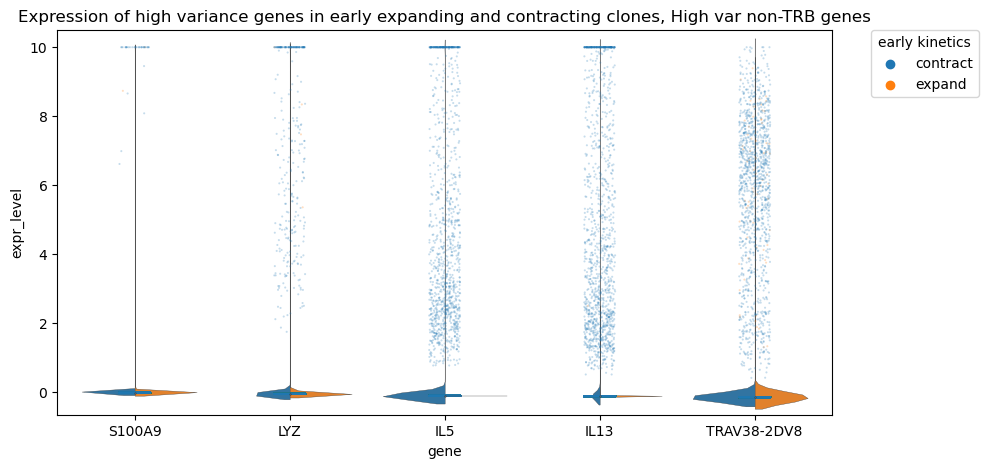

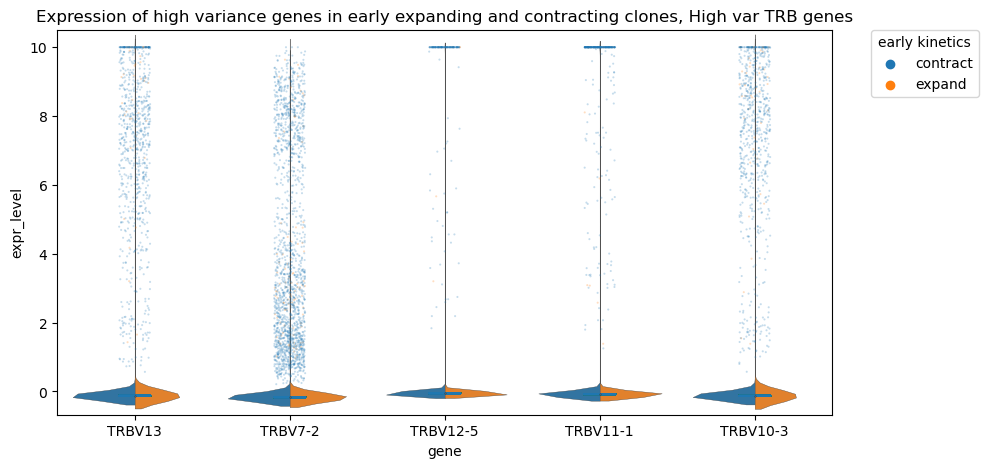

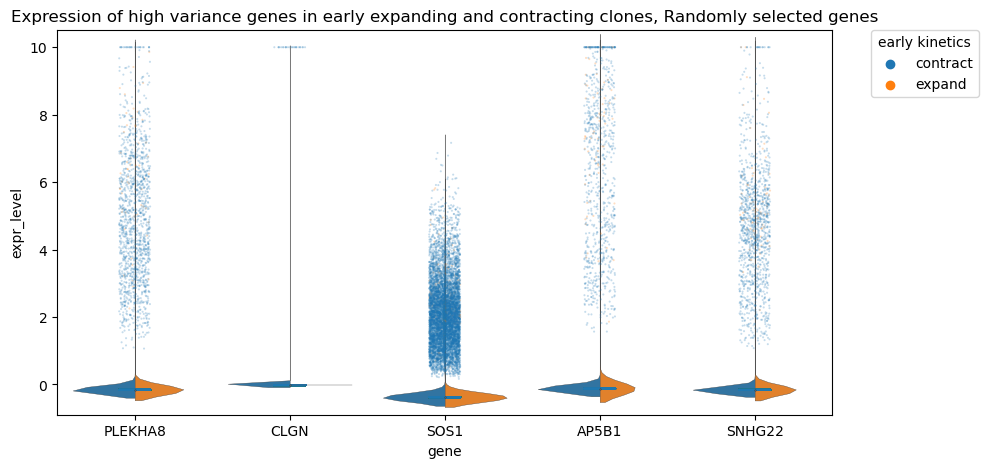

In [20]:
make_violin_plots_for_timepoint("early")

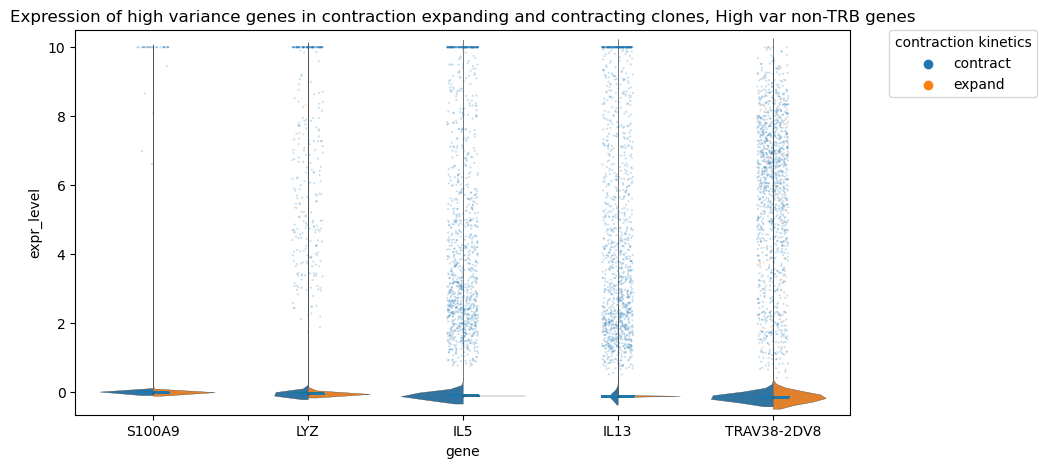

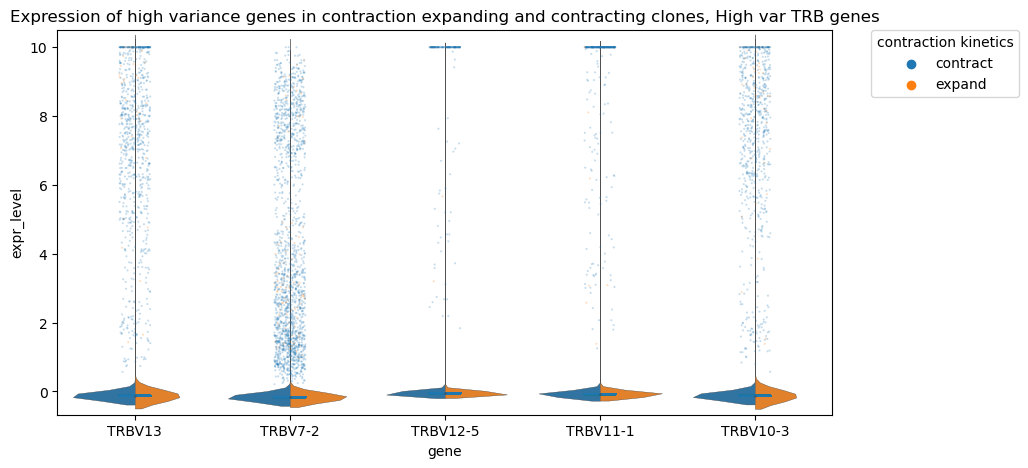

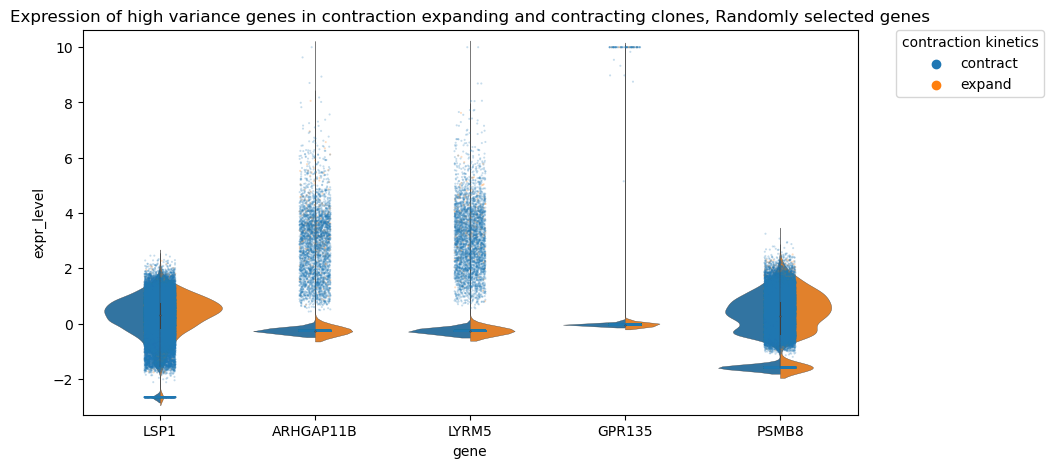

In [25]:
make_violin_plots_for_timepoint("contraction")

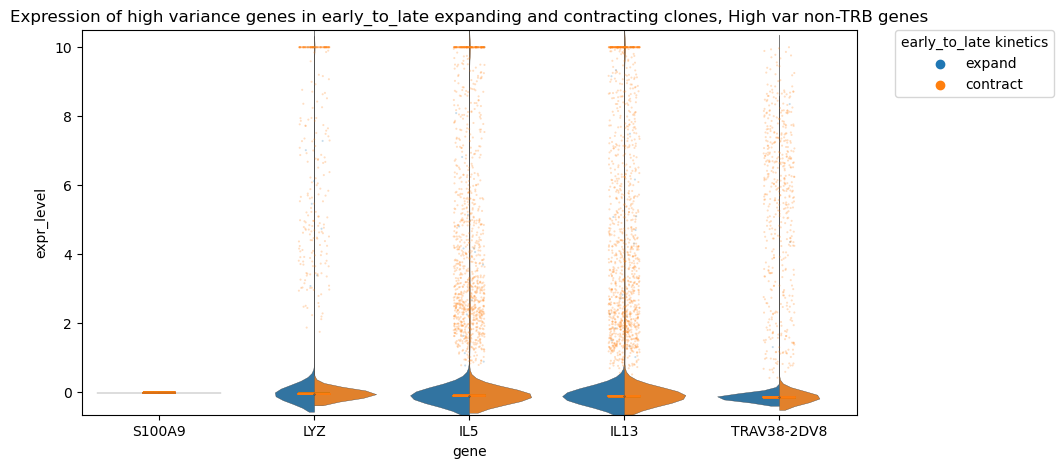

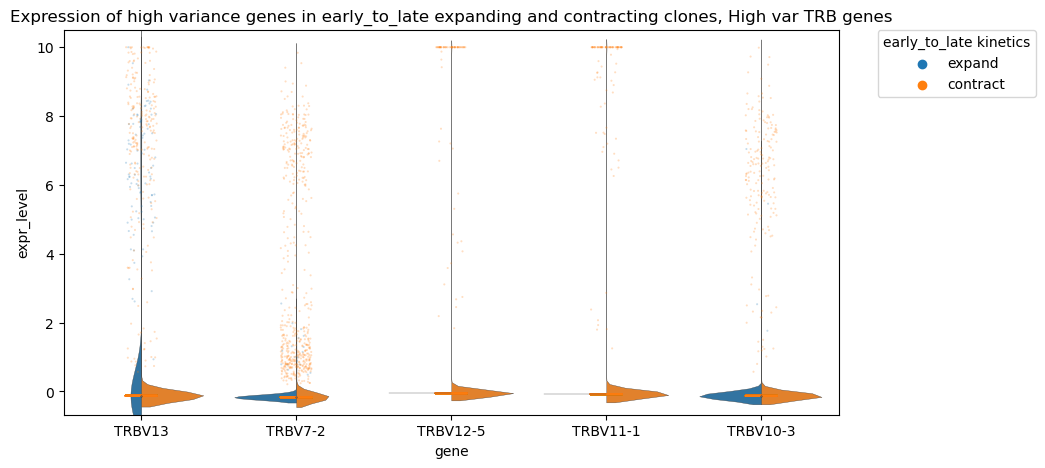

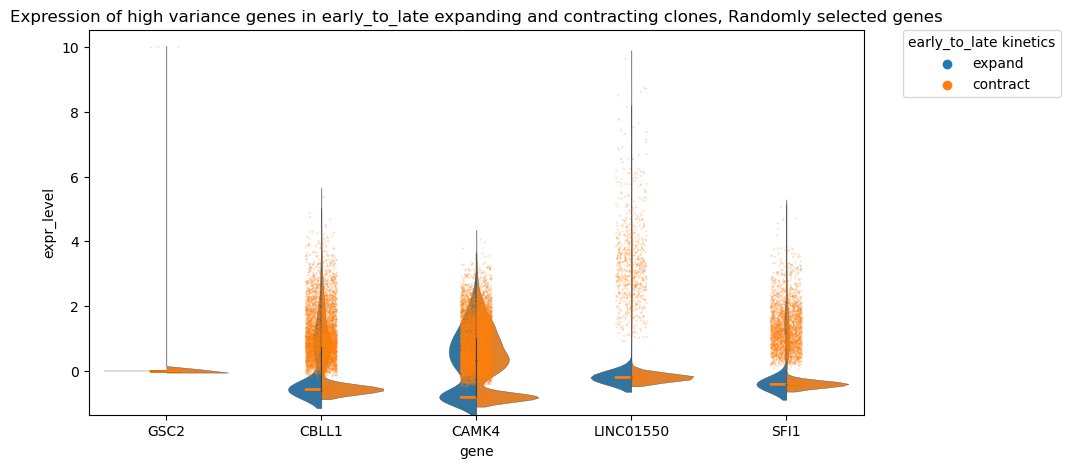

In [247]:
make_violin_plots_for_timepoint("early_to_late")

#### As a sanity check, look more closely into the expression of S100A9, which is a gene that is highly expressed but has very little expression

In [248]:
expr.var.loc["S100A9"]

mt                           False
n_cells_by_counts               77
mean_counts               0.019689
pct_dropout_by_counts     99.87614
total_counts                1224.0
n_cells                         77
highly_variable               True
means                     0.013921
dispersions               4.757143
dispersions_norm         14.140092
trb                          False
mean                       0.00145
std                       0.058021
Name: S100A9, dtype: object

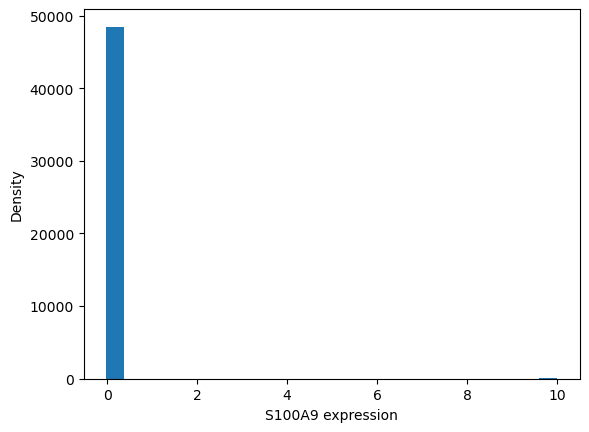

In [249]:
plt.hist(expr_df["S100A9"], bins=25)
plt.xlabel("S100A9 expression")
plt.ylabel("Density")
plt.show()

# it seems like it was only expressed in a very small population of cells (77) and ust happens to have pretty high dispersion because of the few cells that had high expression

## Plot DiffExp based on kinetics at each timepoint 

### Viz where kinetics fit into UMAP

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


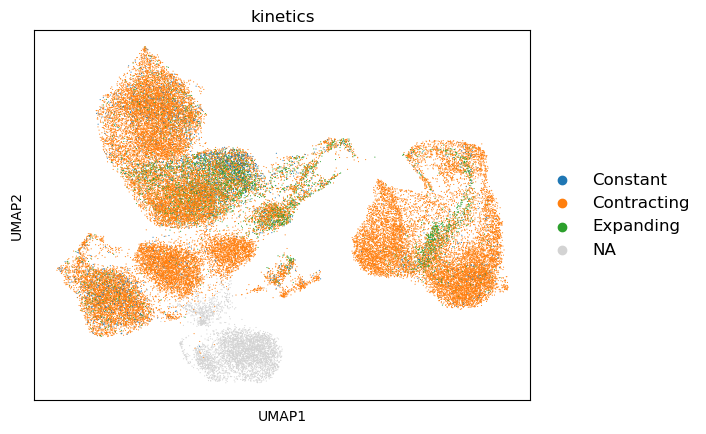

In [250]:
sc.tl.pca(expr)
sc.pp.neighbors(expr, n_pcs=15)
sc.tl.leiden(expr, resolution=0.2)
sc.tl.umap(expr)
fig = sc.pl.umap(expr, color=['kinetics'],
                legend_fontsize = 12)

#### Add in kinetic information for each barcode into expr object

In [26]:
def plot_deg(expr_df: pd.DataFrame, n_genes=25, groupby_var="kinetics"):
    sc.tl.rank_genes_groups(expr_df, groupby=groupby_var, method="wilcoxon", n_genes=1000)
    sc.pl.rank_genes_groups(expr_df, n_genes=n_genes, sharey=False)
    sc.pl.rank_genes_groups_heatmap(expr_df, n_genes = n_genes, key="rank_genes_groups", groupby=groupby_var, show_gene_labels=True, standard_scale="var")

In [27]:
plot_deg(expr[expr.obs.kinetics.notnull()].copy(), n_genes=10)

AttributeError: 'DataFrame' object has no attribute 'kinetics'

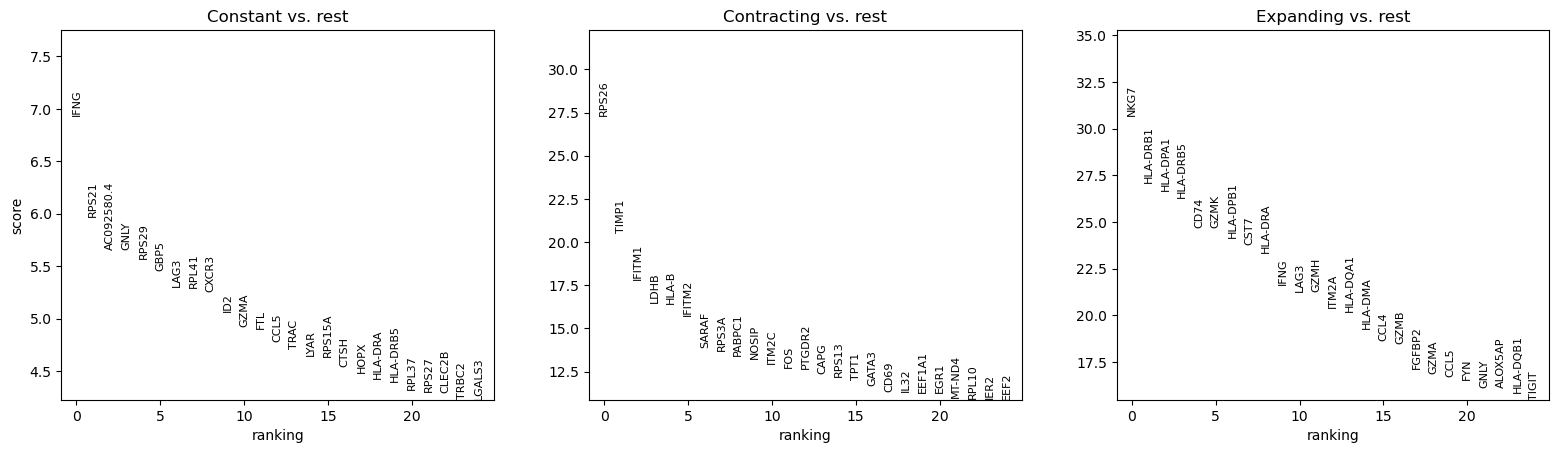

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


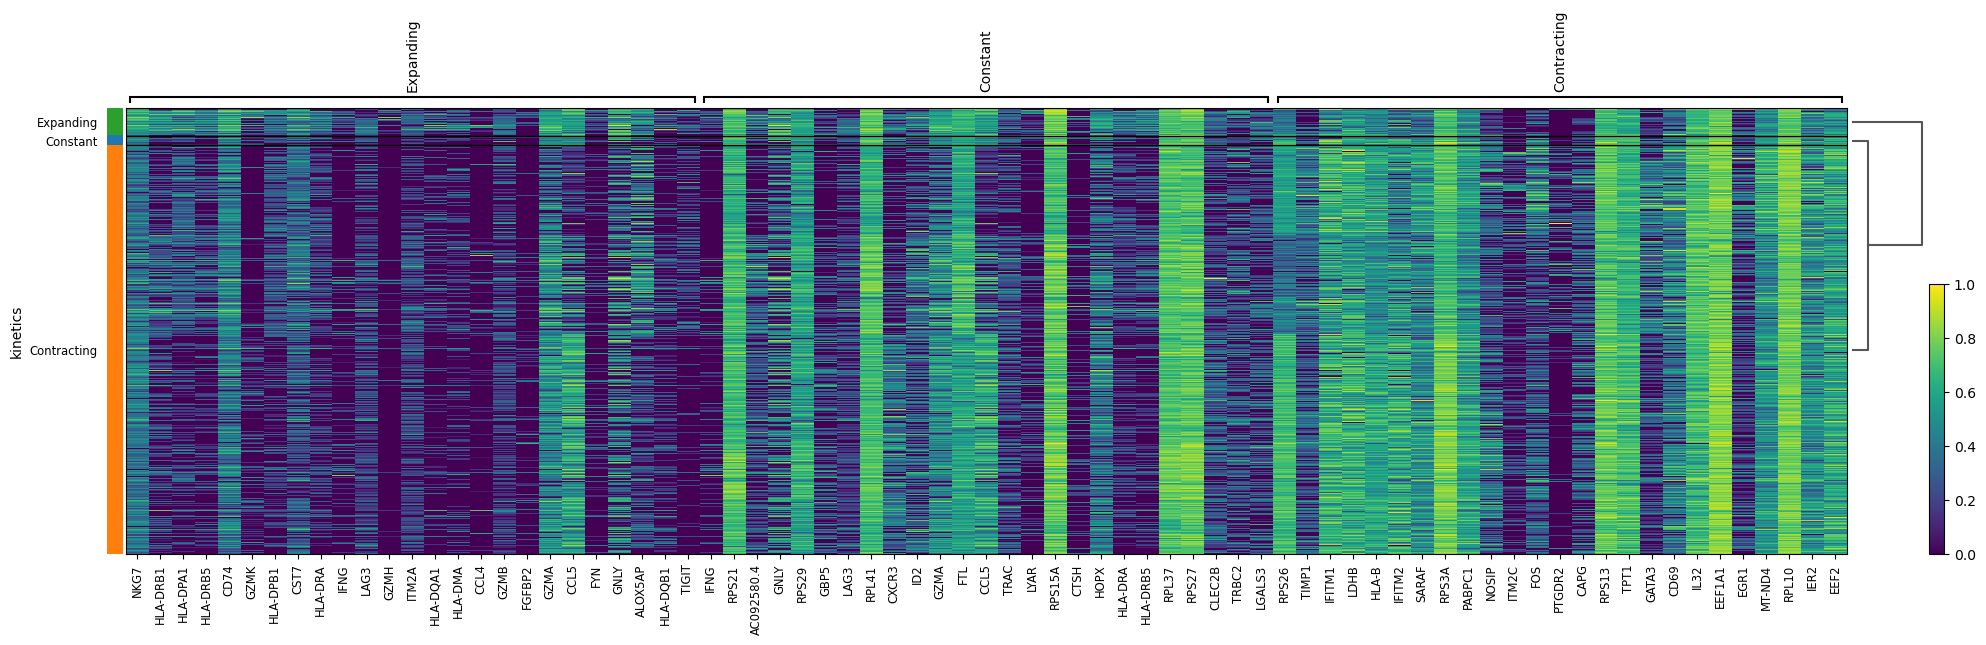

In [19]:
# Plotting the expression values at IP time point, split based on their kinetic values going to early time point
plot_deg(expr[expr.obs["time_point_type"]=="IP"].copy())

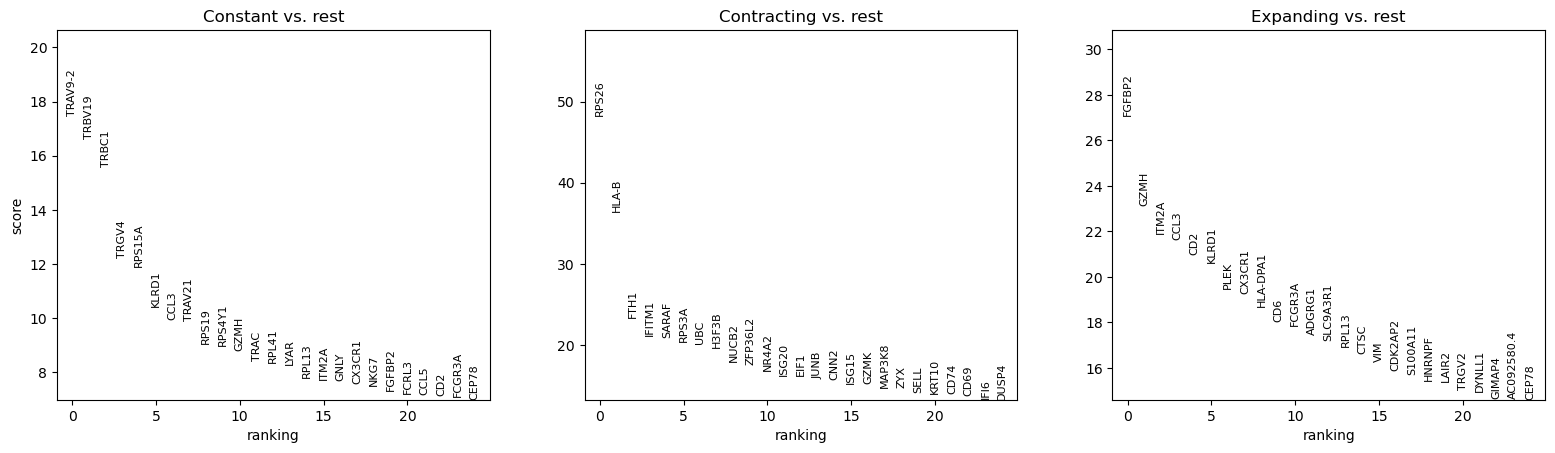

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


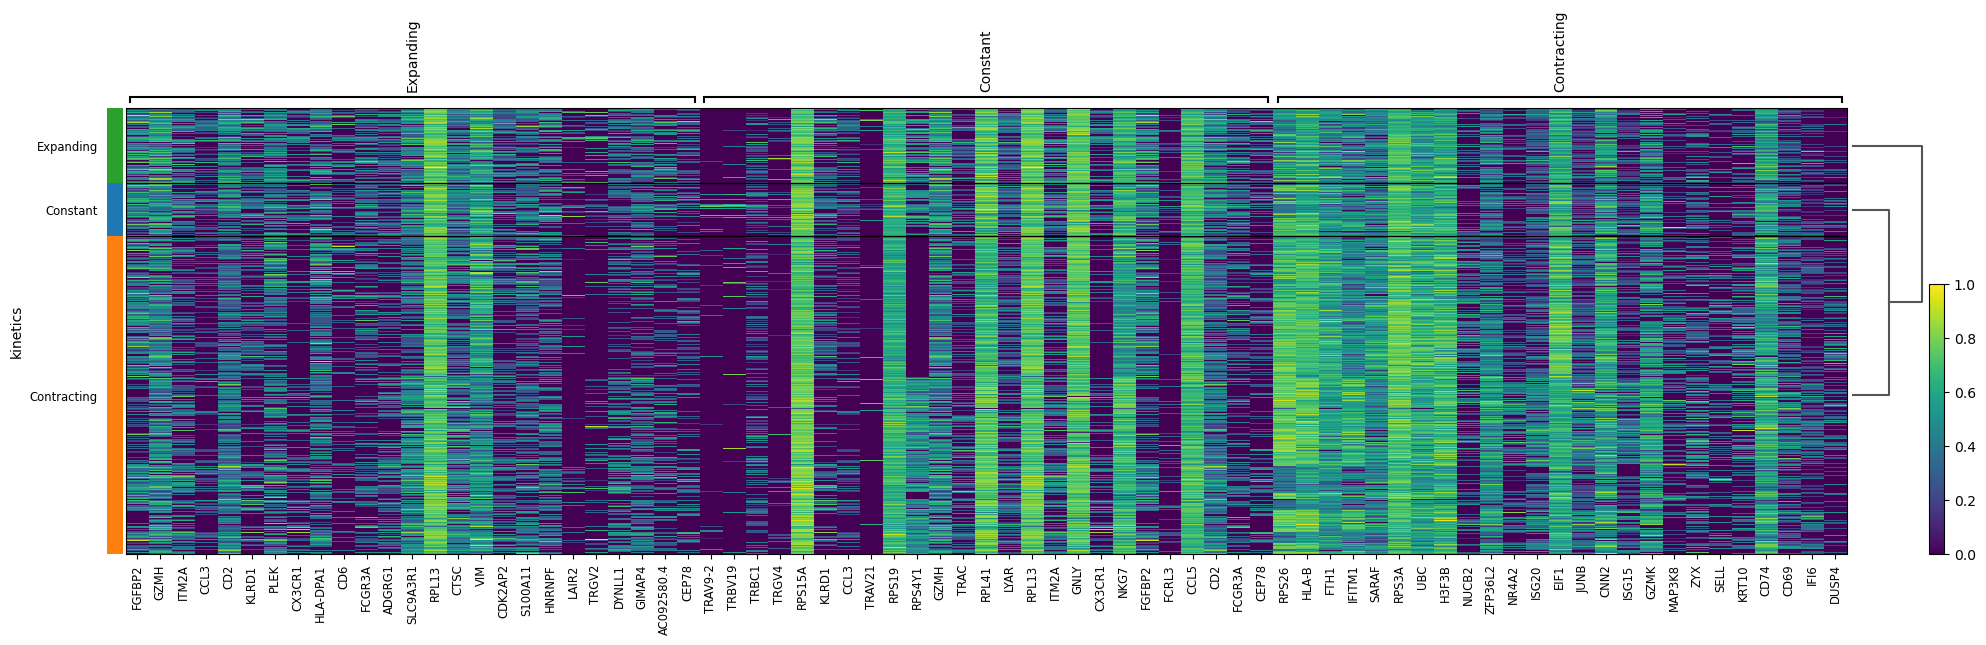

In [20]:
# Plotting the expression values at Contraction time point, split based on their kinetic values going to late time point
plot_deg(expr[expr.obs["time_point_type"]=="Early"].copy())

## Plot just top gene expr _per patient_ (IP to Early only)

CLL-1


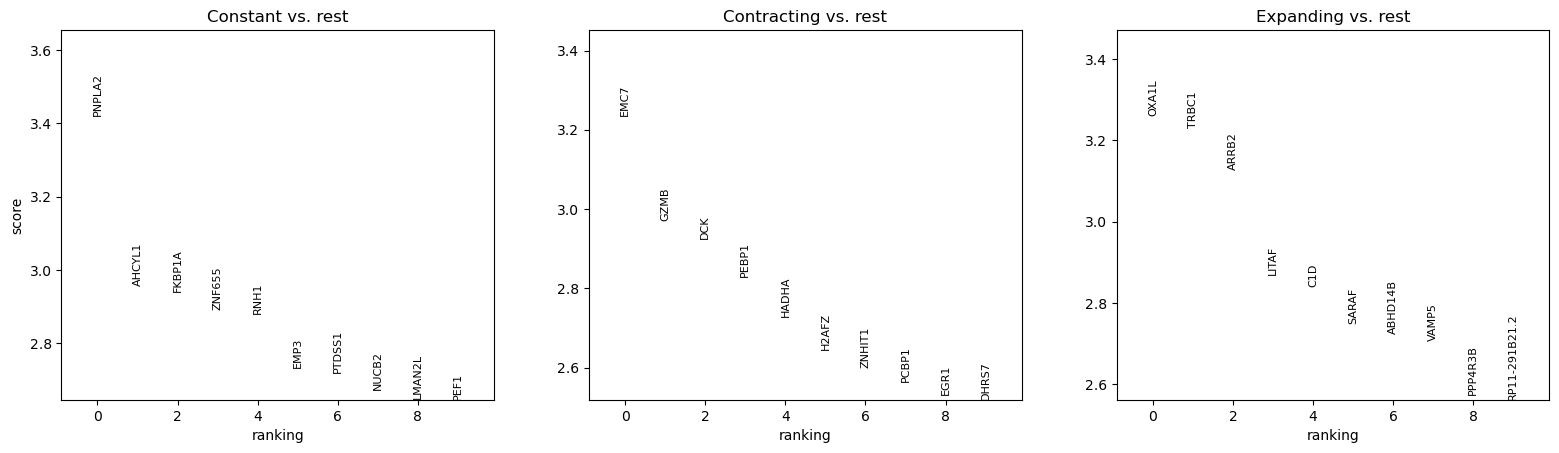

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


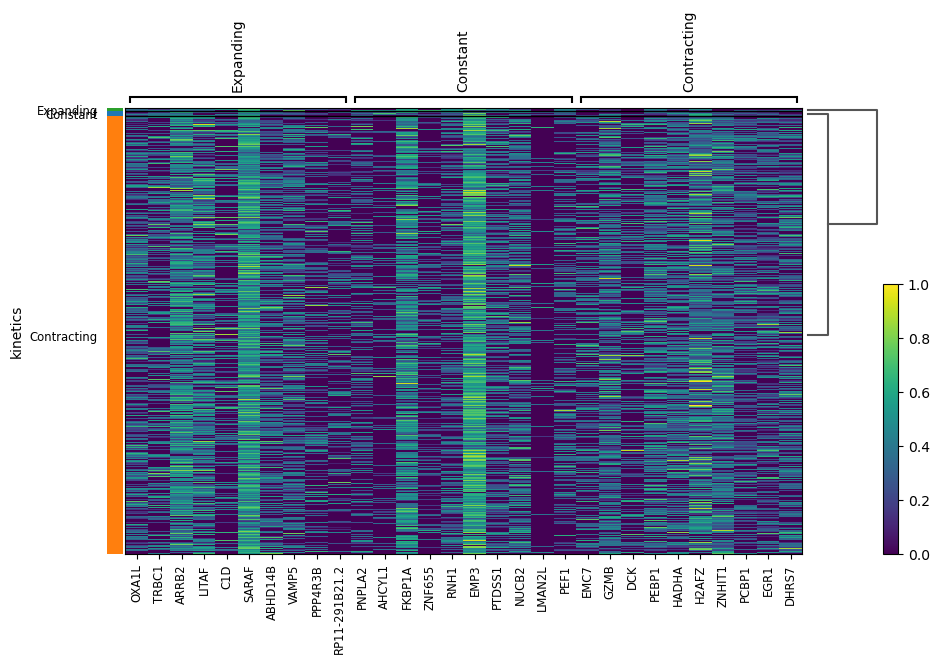

NHL-6


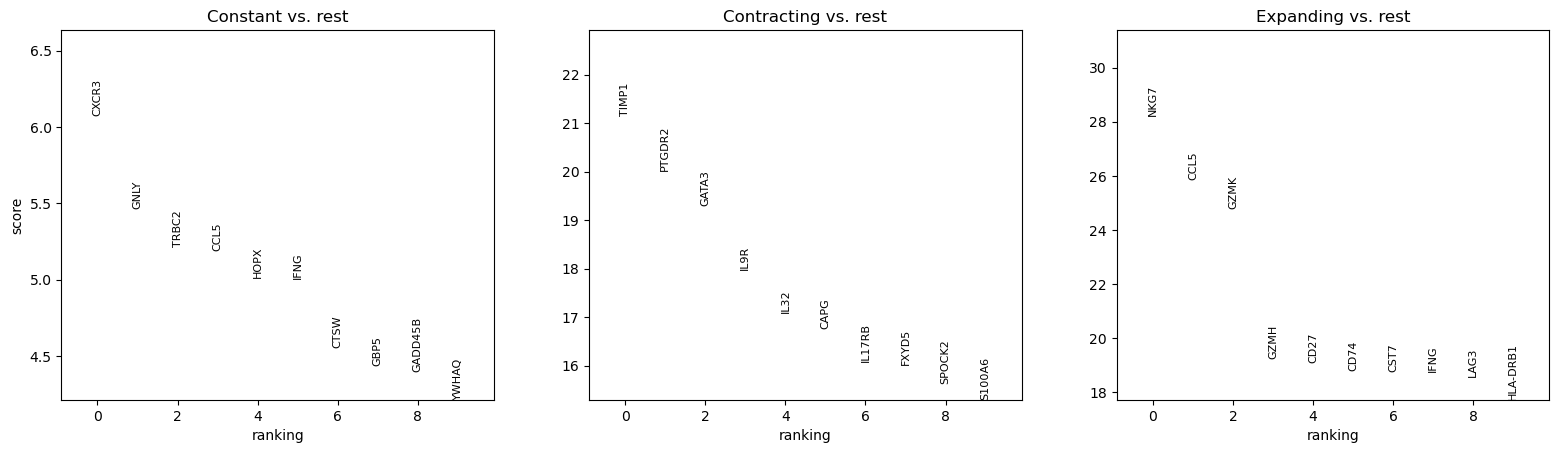

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


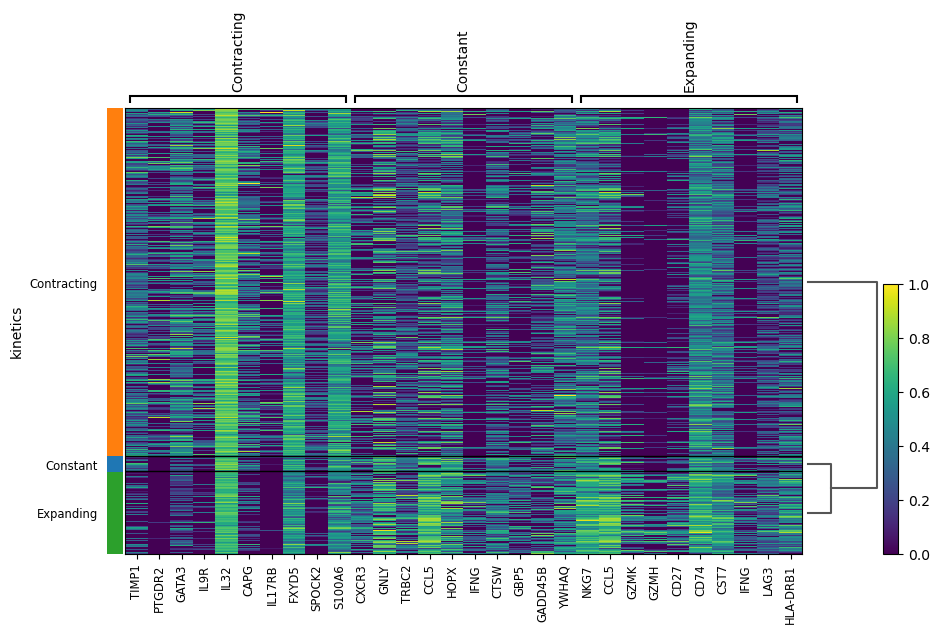

CLL-2


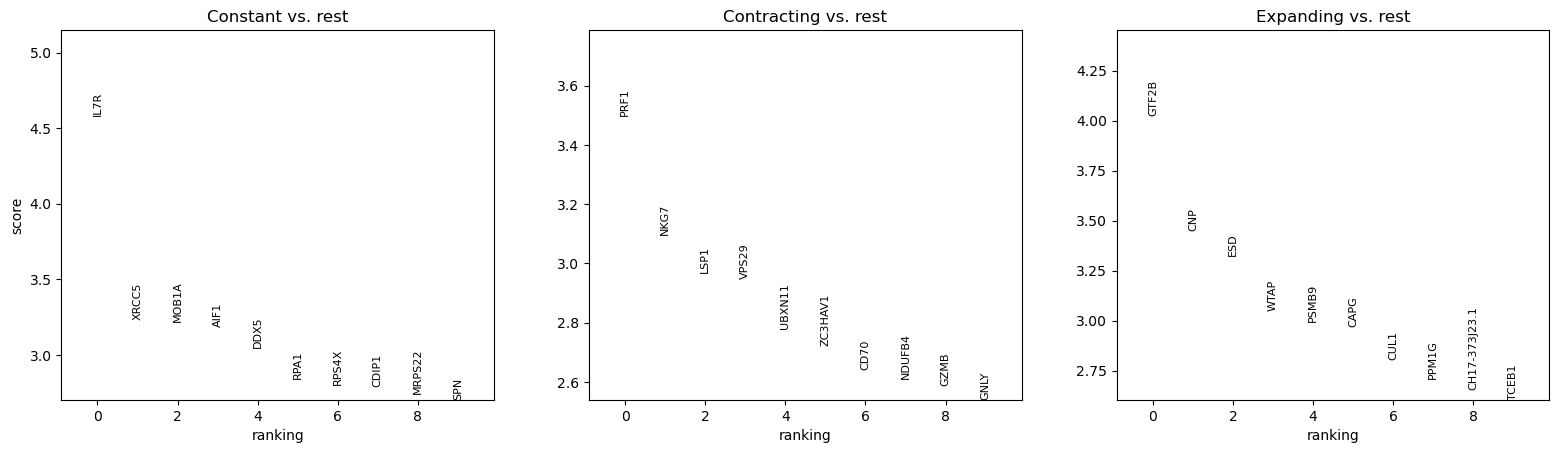

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


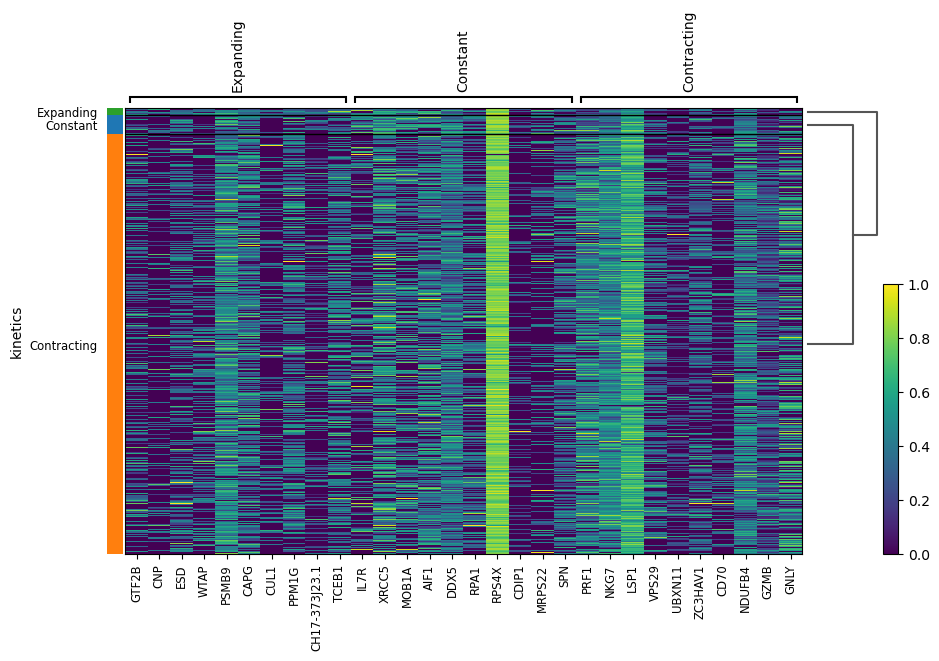

NHL-7


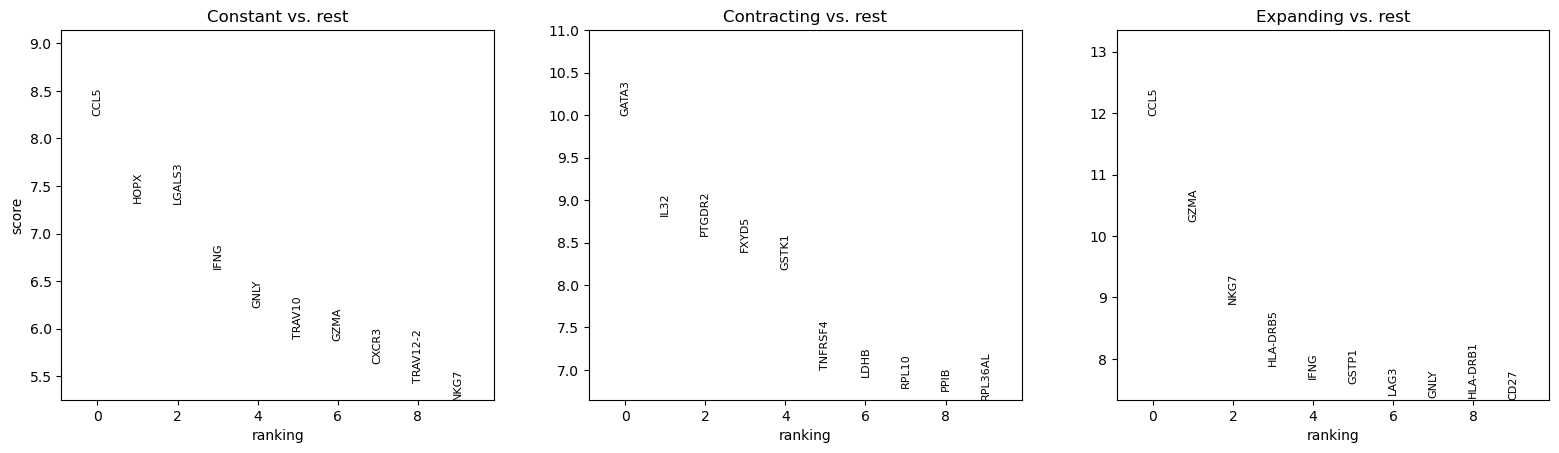

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


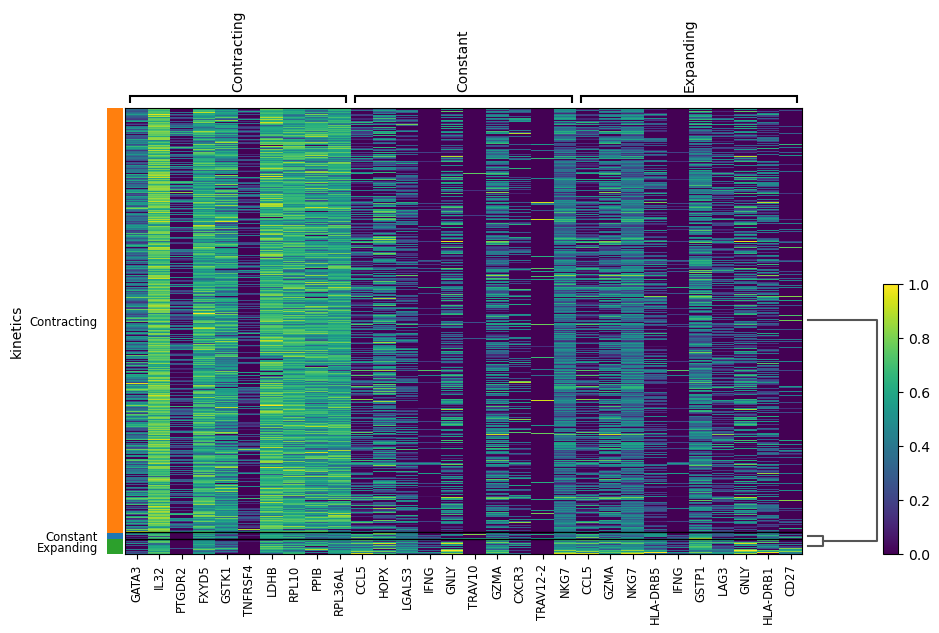

In [ ]:
for pat_id in expr.obs["patient_id"].unique():
    expr_for_time_pt = expr[(expr.obs["time_point_type"]=="IP")&(expr.obs["patient_id"]==pat_id)].copy()
    print(pat_id)
    plot_deg(expr_for_time_pt, n_genes=10)

### Plot DEG _between timepoints_ within all barcodes of one clone
We selected a clone that had very variable behavior

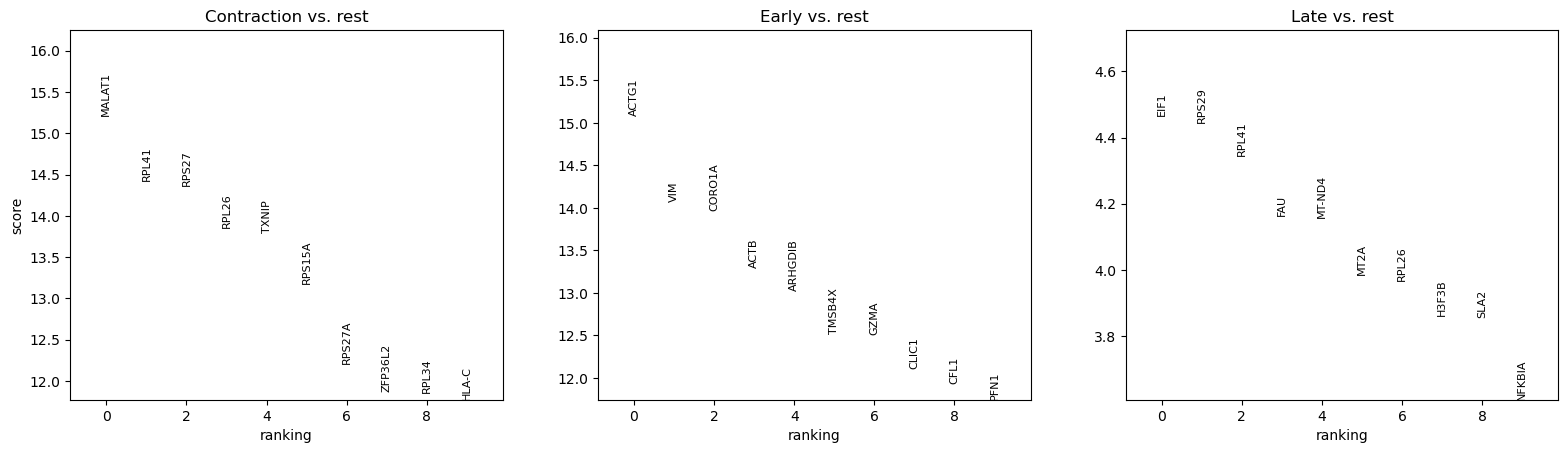

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


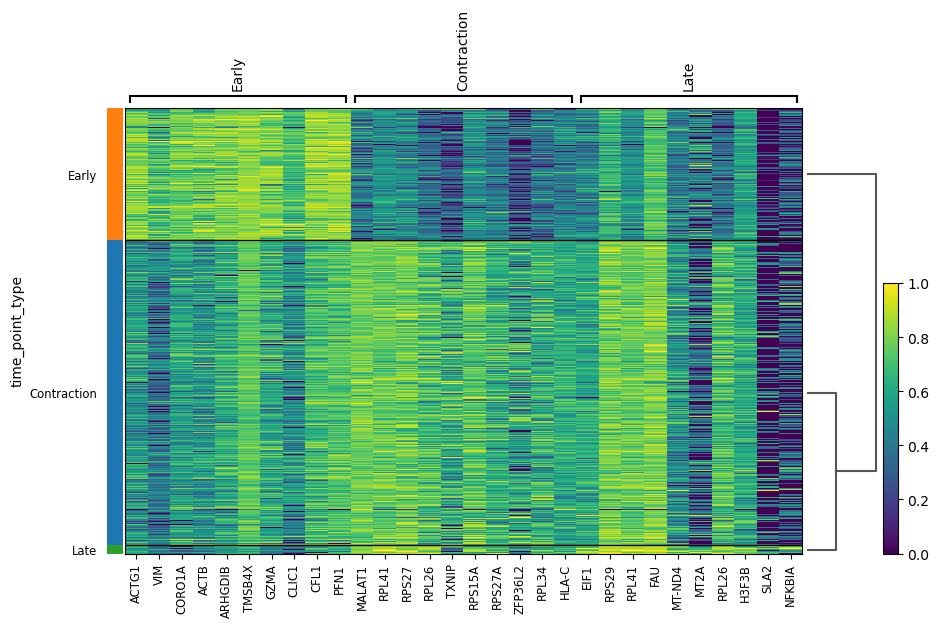

In [ ]:
clone_id = "NHL-7-917"
plot_deg(expr[expr.obs.clone_id == clone_id].copy(), n_genes=10, groupby_var="time_point_type")

## Get list of log2fc & pval for genes that are diff btwn expand and contract/constant in each patient
### Compare top list between patients

In [17]:
import matplotlib.pyplot as plt

In [18]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

In [19]:
# Get average gene exp for all expanding barcodes in cll1
def get_kinetic_log2fc(expr_df):
    exp_df = expr_df[expr_df.obs.kinetics == "Expanding"]
    exp_df = pd.DataFrame(exp_df.X, index=exp_df.obs.index, columns=exp_df.var.index)
    contr_df = expr_df[expr_df.obs.kinetics == "Contracting"]
    contr_df = pd.DataFrame(contr_df.X, index=contr_df.obs.index, columns=contr_df.var.index)
    log2_fc = np.log2(exp_df+1).mean(axis=0) - np.log2(contr_df+1).mean(axis=0)
    print(f"{exp_df.shape} Expanders, {contr_df.shape} Contracters")

    # calc p-values
    pvals = {}
    for gene in expr_df.var.index:
        _, pval = ranksums(exp_df[gene], contr_df[gene])
        pvals[gene] = pval

    # combine into one dataframe
    stats_df = pd.DataFrame({'log2_fc': log2_fc, 'pval': pvals})

    stats_df['qval'] = multipletests(stats_df.pval, method="fdr_bh")[1]
    stats_df['-log10(pval)'] = -np.log10(stats_df['pval'])
    stats_df['-log10(qval)'] = -np.log10(stats_df['qval'])

    return stats_df

def plot_volcano(toplot, xname, yname, nlabel, title="Volcano Plot"):
    #setup figure/axes
    fig,ax=plt.subplots(figsize=(8,8))

    #plot points
    sns.scatterplot(data=toplot, x=xname, y=yname, alpha=0.75, s=15)
    tolabel = toplot.nlargest(nlabel, yname)
    for k,row in tolabel.iterrows():
        plt.text(row[xname], row[yname], row.name, fontsize=8, rotation=60)

    #axes formatting
    plt.title(title)
    plt.axhline(-np.log10(0.05), linestyle="--", color="black", label="q=0.05")
    sns.despine()
    plt.legend()
    plt.xlim(-8,8)
    plt.show()
    

CLL-1


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


(27, 20107) Expanders, (4742, 20107) Contracters


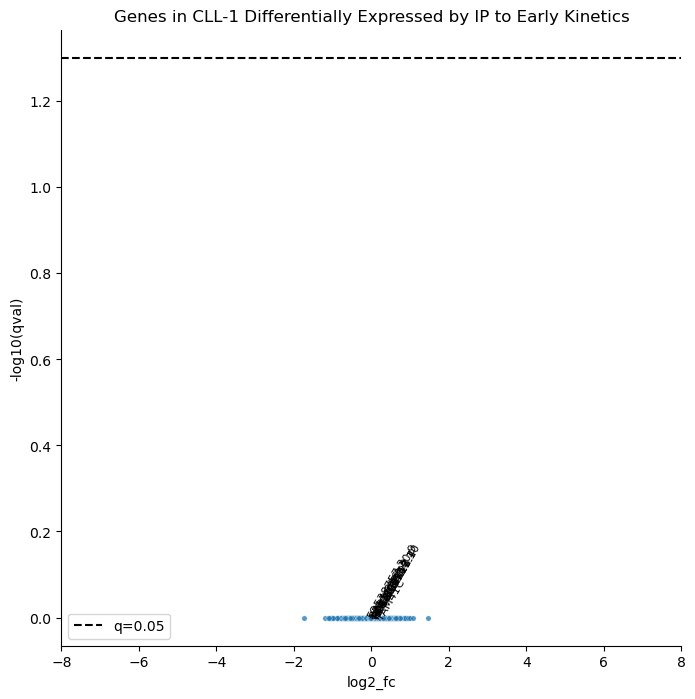

NHL-6


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


(632, 20107) Expanders, (2670, 20107) Contracters


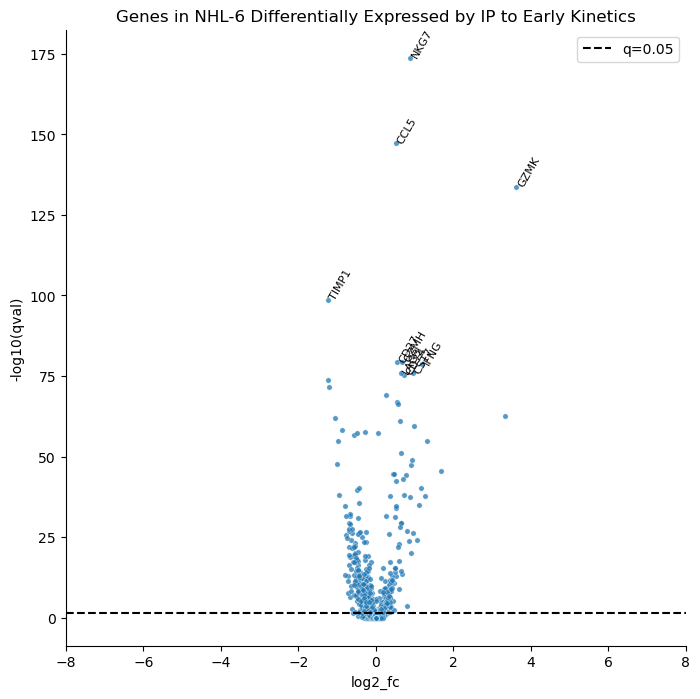

CLL-2


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


(24, 20107) Expanders, (1436, 20107) Contracters


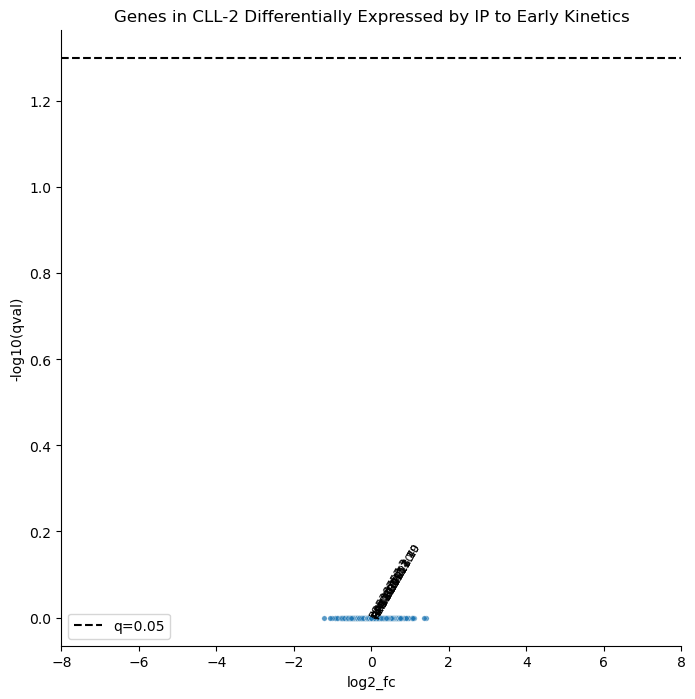

NHL-7


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


(102, 20107) Expanders, (2871, 20107) Contracters


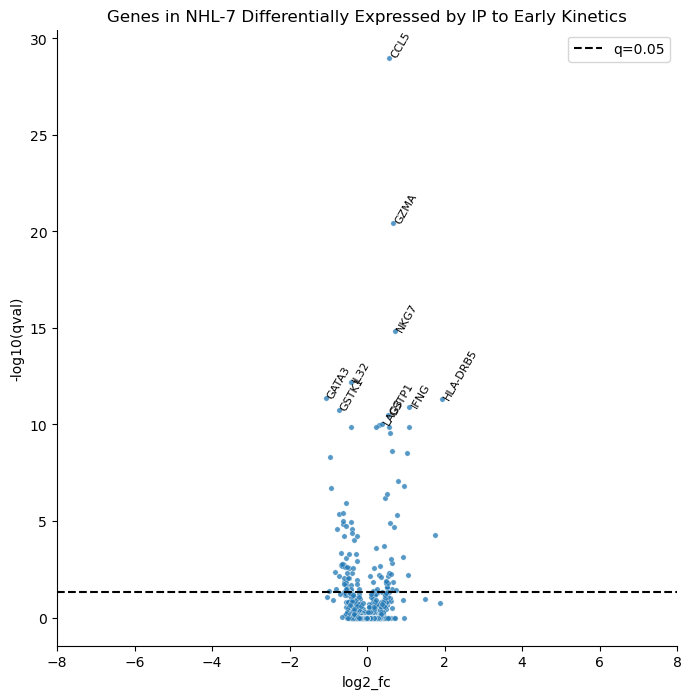

In [231]:
stats_df_per_pat = {}
for pat_id in expr.obs.patient_id.unique():
    print(pat_id)
    expr_df_ip_for_pat = expr[(expr.obs.patient_id == pat_id) & (expr.obs.time_point_type == "IP")] #  
    stats_df_per_pat[pat_id] = get_kinetic_log2fc(expr_df_ip_for_pat)
    plot_volcano(stats_df_per_pat[pat_id],
                  xname="log2_fc", yname="-log10(qval)", nlabel=10, title=f"Genes in {pat_id} Differentially Expressed by IP to Early Kinetics")

In [29]:
cll1_expanding_genes = stats_df_per_pat["CLL-1"].query("qval < 0.05 and log2_fc > 0").index
cll1_contracting_genes = stats_df_per_pat["CLL-1"].query("qval < 0.05 and log2_fc < 0").index
cll2_expanding_genes = stats_df_per_pat["CLL-2"].query("qval < 0.05 and log2_fc > 0").index
cll2_contracting_genes = stats_df_per_pat["CLL-2"].query("qval < 0.05 and log2_fc < 0").index
nhl6_expanding_genes = stats_df_per_pat["NHL-6"].query("qval < 0.05 and log2_fc > 0").index
nhl6_contracting_genes = stats_df_per_pat["NHL-6"].query("qval < 0.05 and log2_fc < 0").index
nhl7_expanding_genes = stats_df_per_pat["NHL-7"].query("qval < 0.05 and log2_fc > 0").index
nhl7_contracting_genes = stats_df_per_pat["NHL-7"].query("qval < 0.05 and log2_fc < 0").index

In [25]:
from venn import venn

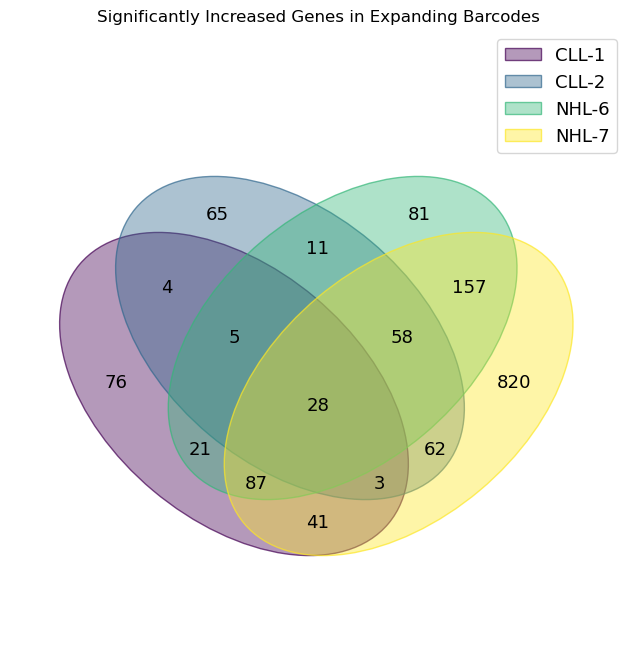

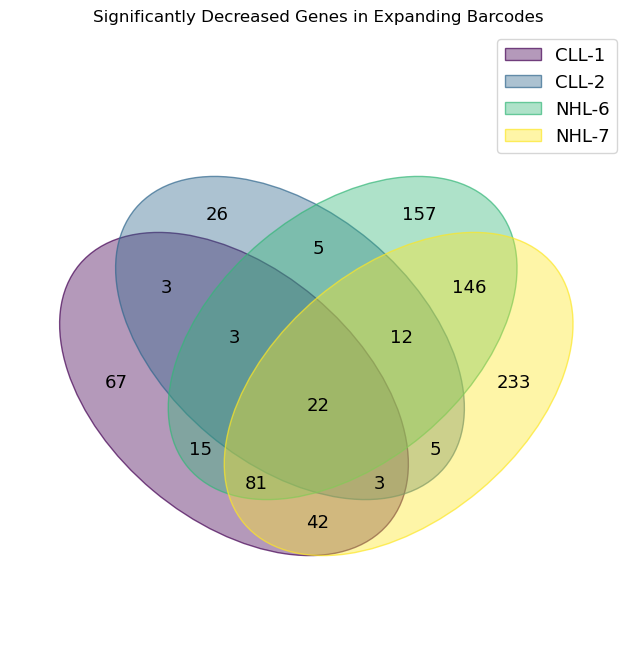

In [35]:
venn({"CLL-1": set(cll1_expanding_genes), "CLL-2": set(cll2_expanding_genes), "NHL-6": set(nhl6_expanding_genes), "NHL-7": set(nhl7_expanding_genes)},
     ) # fmt="{percentage:.1f}%",
plt.title("Significantly Increased Genes in Expanding Barcodes")
plt.show()

venn({"CLL-1": set(cll1_contracting_genes), "CLL-2": set(cll2_contracting_genes), "NHL-6": set(nhl6_contracting_genes), "NHL-7": set(nhl7_contracting_genes)},
     )
plt.title("Significantly Decreased Genes in Expanding Barcodes")
plt.show()

In [37]:
# get list of genes that are significantly expanding in all patients
all_expanding_genes = set(cll1_expanding_genes).intersection(set(cll2_expanding_genes)).intersection(set(nhl6_expanding_genes)).intersection(set(nhl7_expanding_genes))
all_contracting_genes = set(cll1_contracting_genes).intersection(set(cll2_contracting_genes)).intersection(set(nhl6_contracting_genes)).intersection(set(nhl7_contracting_genes))
all_sig_genes = all_expanding_genes.union(all_contracting_genes)

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


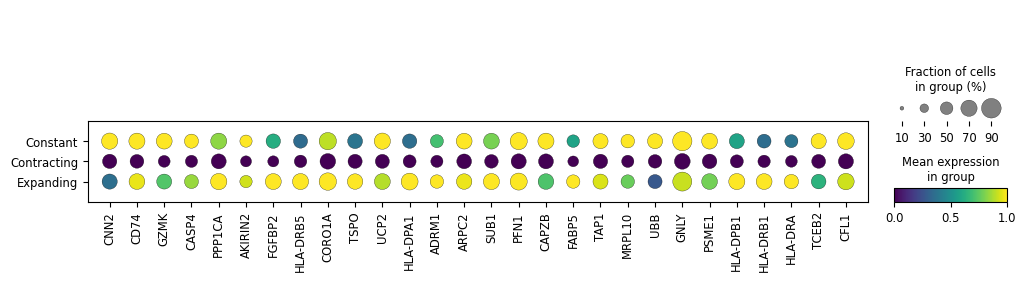

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


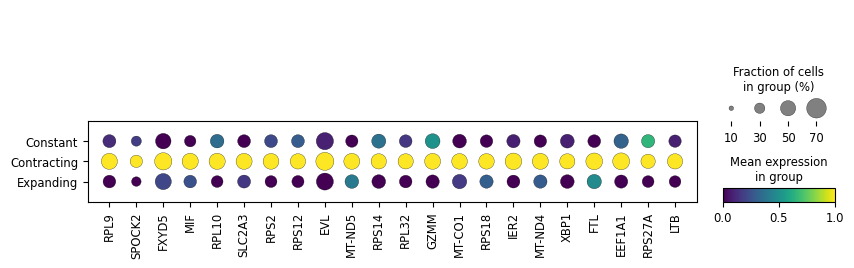

In [47]:
sc.pl.dotplot(expr, var_names=list(all_expanding_genes), groupby="kinetics", use_raw=False, standard_scale="var", color_map="viridis")
sc.pl.dotplot(expr, var_names=list(all_contracting_genes), groupby="kinetics", use_raw=False, standard_scale="var", color_map="viridis")

#### Check if expansion of sig genes is correlated with expression level

In [51]:
clone_counts = pd.read_csv("tcr_clone_counts.csv")
clone_counts = clone_counts.set_index("clone_id")[["early_expansion", "contraction_expansion", "late_expansion"]].rename({"early_expansion": "IP", "contraction_expansion": "Early", "late_expansion": "Contraction"}, axis=1)
clone_to_expansion_per_tp = clone_counts.to_dict()
expr_non_late = expr[expr.obs.time_point_type != "Late"]
expr_non_late.obs["Expansion_level"] = expr_non_late.obs.apply(lambda x: clone_to_expansion_per_tp[x.time_point_type][x.clone_id], axis=1)

In [82]:
# plot expression level of gene vs expansion level
def plot_gene_expansion(gene):
    fig,ax=plt.subplots(figsize=(8,8))
    sns.scatterplot(data=expr_non_late.obs, x="Expansion_level", y=gene, hue="time_point_type", s=15)
    plt.show()

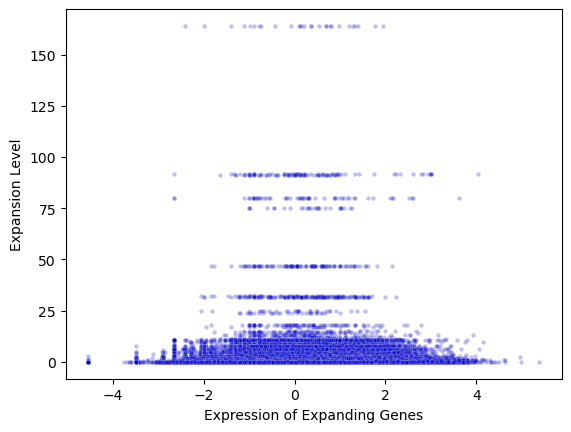

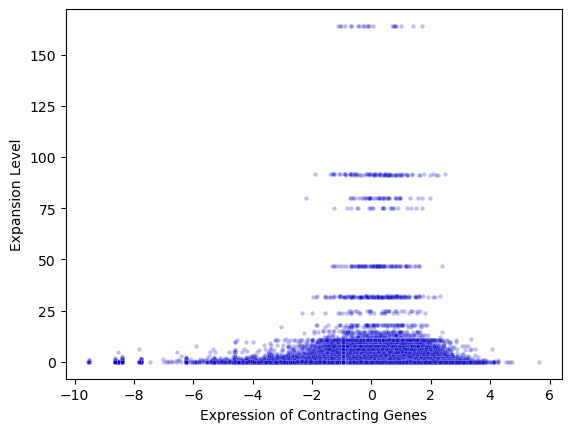

In [106]:
# make dataframe of expr_non_late
expr_non_late_df = expr_non_late.to_df()
for gene in all_expanding_genes:
    sns.scatterplot(x=expr_non_late_df[gene], y=expr_non_late.obs["Expansion_level"], s=10, c="mediumblue", alpha=0.25)
plt.xlabel("Expression of Expanding Genes")
plt.ylabel("Expansion Level")
plt.show()

for gene in all_contracting_genes:
    sns.scatterplot(x=expr_non_late_df[gene], y=expr_non_late.obs["Expansion_level"], s=10, c="mediumblue", alpha=0.25)
plt.xlabel("Expression of Contracting Genes")
plt.ylabel("Expansion Level")
plt.show()

In [109]:
import gseapy

In [143]:
# enr_res = gseapy.enrichr(gene_list=stats_df_per_pat["CLL-1"],
#                      organism='Human',
#                      gene_sets='MSigDB_Hallmark_2020',
#                      cutoff = 0.5)

In [175]:
avg_log2fc_per_gene = pd.concat(stats_df_per_pat.values(), axis=1)["log2_fc"].mean(axis=1)

In [188]:
import time

CLL-1
['Interferon Alpha Response', 'Interferon Gamma Response', 'Myc Targets V1', 'Hypoxia', 'Glycolysis', 'mTORC1 Signaling', 'IL-2/STAT5 Signaling', 'Oxidative Phosphorylation', 'Complement', 'Fatty Acid Metabolism']
CLL-2
['TNF-alpha Signaling via NF-kB', 'Hypoxia', 'IL-2/STAT5 Signaling', 'Allograft Rejection', 'p53 Pathway', 'G2-M Checkpoint', 'Myc Targets V1', 'E2F Targets', 'Inflammatory Response', 'Adipogenesis']
NHL-6
['IL-2/STAT5 Signaling', 'IL-6/JAK/STAT3 Signaling', 'Unfolded Protein Response', 'G2-M Checkpoint', 'Complement', 'Inflammatory Response', 'Epithelial Mesenchymal Transition', 'Allograft Rejection', 'UV Response Dn', 'Reactive Oxygen Species Pathway']
NHL-7
['Hypoxia', 'TNF-alpha Signaling via NF-kB', 'IL-2/STAT5 Signaling', 'Inflammatory Response', 'IL-6/JAK/STAT3 Signaling', 'Epithelial Mesenchymal Transition', 'Oxidative Phosphorylation', 'E2F Targets', 'p53 Pathway', 'G2-M Checkpoint']


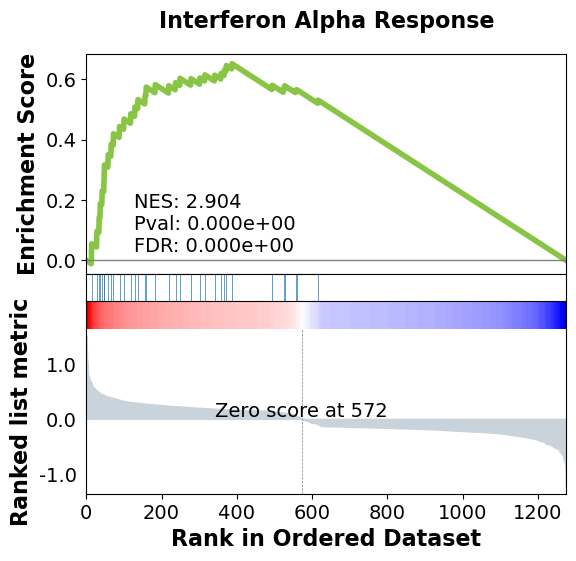

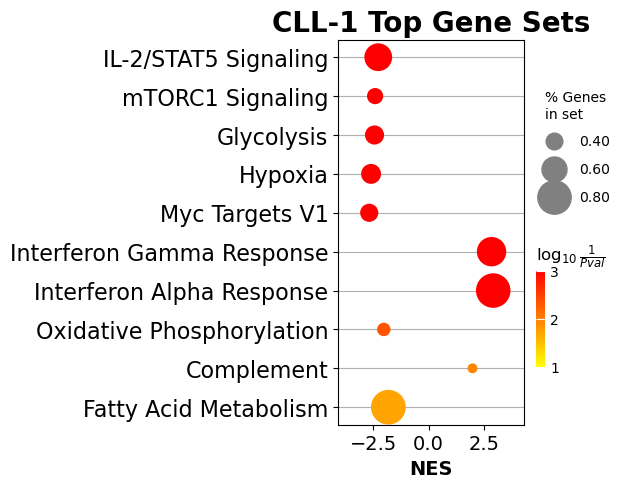

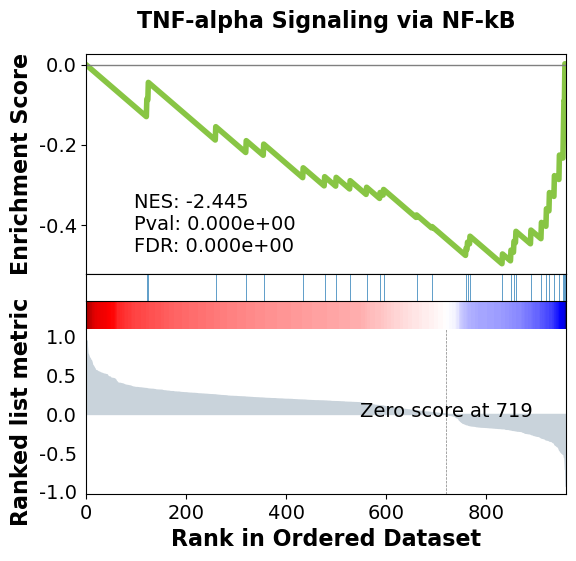

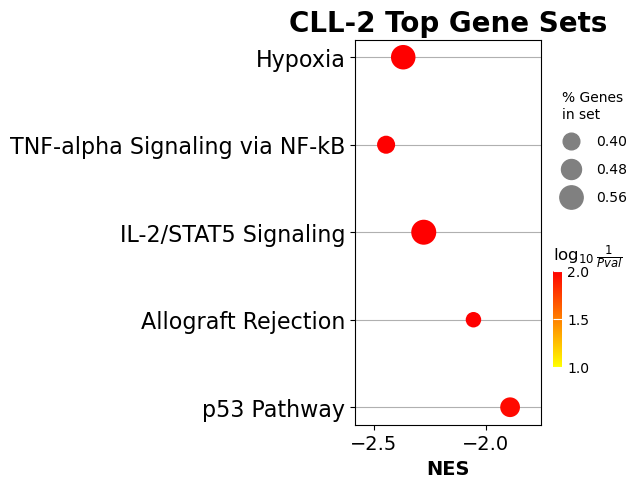

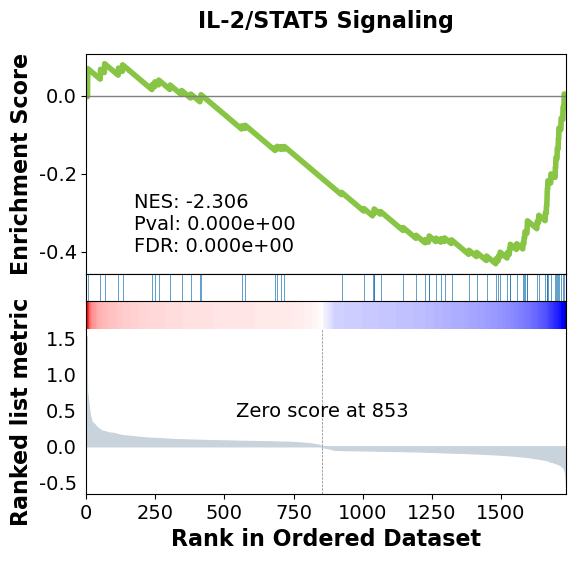

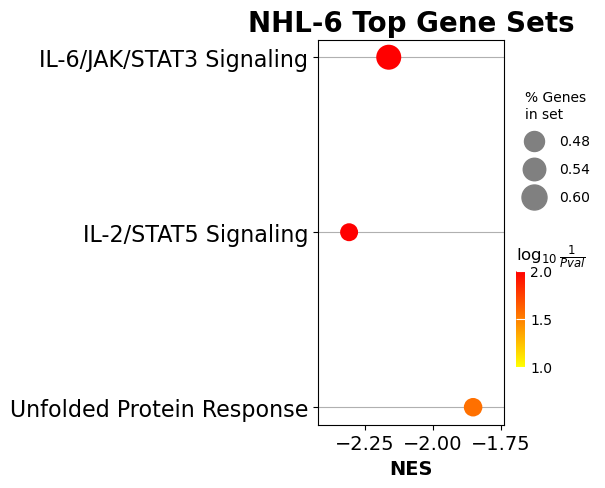

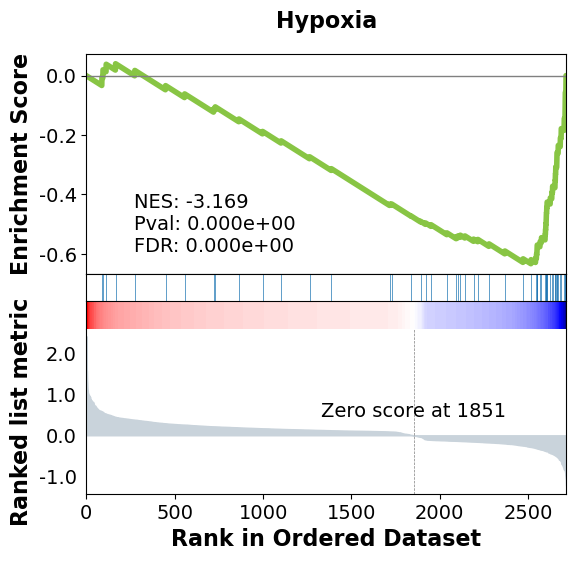

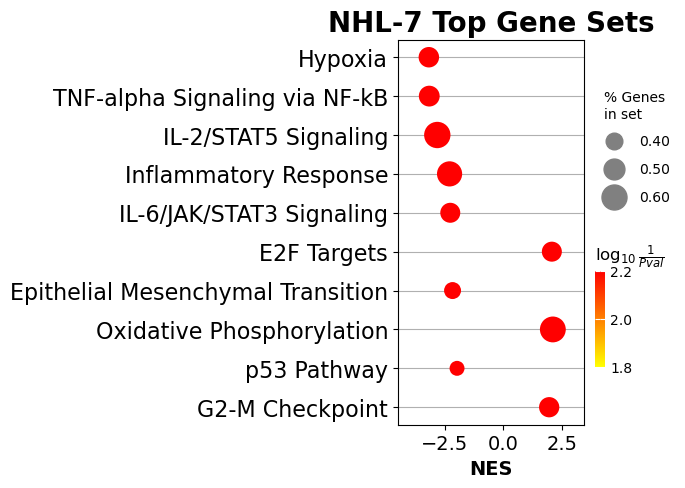

In [193]:
# IP to Early Expr
for pat in ["CLL-1", "CLL-2", "NHL-6", "NHL-7"]:
    print(pat)
    enr_res = gseapy.prerank(rnk=stats_df_per_pat[pat].query("pval < 0.05")["log2_fc"], gene_sets='MSigDB_Hallmark_2020')

    print([enr_res.res2d.Term[i] for i in range(10)])

    gseapy.gseaplot(rank_metric=enr_res.ranking, term=enr_res.res2d.Term[0], **enr_res.results[enr_res.res2d.Term[0]])
    enr_res.res2d["Adjusted P-value"] = enr_res.res2d["FDR q-val"]
    gseapy.dotplot(enr_res.res2d, figsize=(3,5), title=f"{pat} Top Gene Sets", cmap = plt.cm.autumn_r, show_category=True)
    
    # gseapy.barplot(enr_res.res2d,title='MSigDB_Hallmark_2020')
    # gseapy.gseaplot(rank_metric=enr_res.ranking, term=enr_res.res2d.Term[1], **enr_res.results[enr_res.res2d.Term[1]])

### GSEA across all time points

CLL-1


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


(375, 20107) Expanders, (12524, 20107) Contracters
NHL-6


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


(2990, 20107) Expanders, (9134, 20107) Contracters
CLL-2


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


(322, 20107) Expanders, (9493, 20107) Contracters
NHL-7


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


(677, 20107) Expanders, (6158, 20107) Contracters
CLL-1
['Interferon Alpha Response', 'Interferon Gamma Response', 'Myc Targets V1', 'Hypoxia', 'Glycolysis', 'mTORC1 Signaling', 'IL-2/STAT5 Signaling', 'Oxidative Phosphorylation', 'Complement', 'Fatty Acid Metabolism']
CLL-2
['TNF-alpha Signaling via NF-kB', 'Hypoxia', 'IL-2/STAT5 Signaling', 'Allograft Rejection', 'p53 Pathway', 'G2-M Checkpoint', 'Myc Targets V1', 'E2F Targets', 'Inflammatory Response', 'Adipogenesis']
NHL-6
['IL-2/STAT5 Signaling', 'IL-6/JAK/STAT3 Signaling', 'Unfolded Protein Response', 'G2-M Checkpoint', 'Complement', 'Inflammatory Response', 'Epithelial Mesenchymal Transition', 'Allograft Rejection', 'UV Response Dn', 'Reactive Oxygen Species Pathway']
NHL-7
['Hypoxia', 'TNF-alpha Signaling via NF-kB', 'IL-2/STAT5 Signaling', 'Inflammatory Response', 'IL-6/JAK/STAT3 Signaling', 'Epithelial Mesenchymal Transition', 'Oxidative Phosphorylation', 'E2F Targets', 'p53 Pathway', 'G2-M Checkpoint']


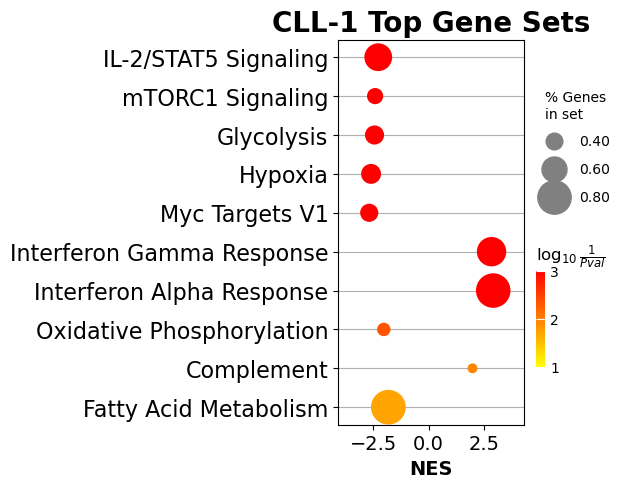

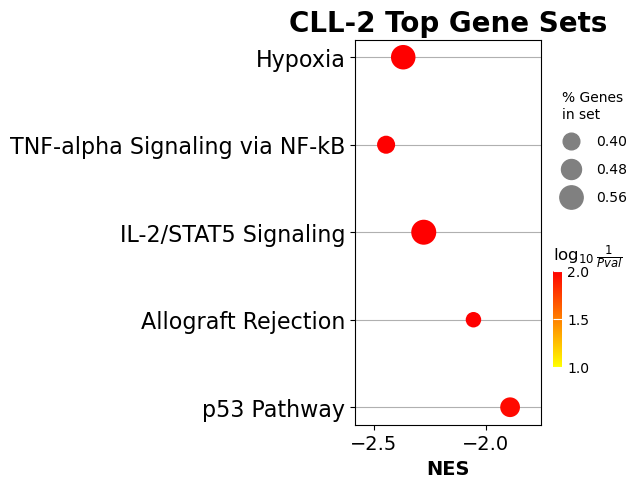

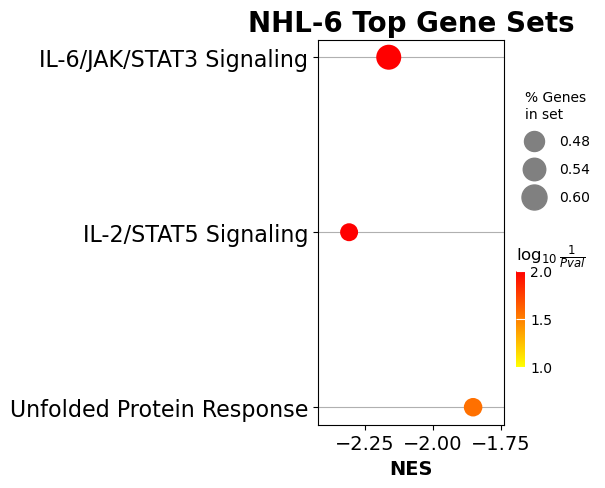

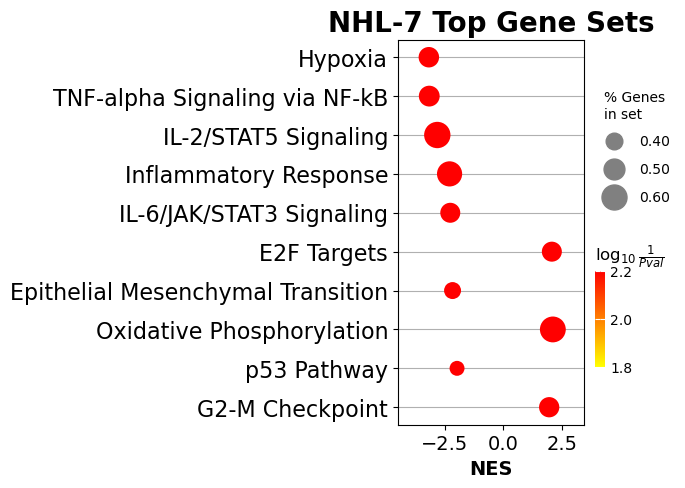

In [233]:
stats_df_per_pat_all_time = {}
for pat_id in expr.obs.patient_id.unique():
    print(pat_id)
    expr_df_ip_for_pat = expr[(expr.obs.patient_id == pat_id)] #  
    stats_df_per_pat_all_time[pat_id] = get_kinetic_log2fc(expr_df_ip_for_pat)

for pat in ["CLL-1", "CLL-2", "NHL-6", "NHL-7"]:
    print(pat)
    enr_res = gseapy.prerank(rnk=stats_df_per_pat_all_time[pat].query("pval < 0.05")["log2_fc"], gene_sets='MSigDB_Hallmark_2020')

    print([enr_res.res2d.Term[i] for i in range(10)])

    # gseapy.gseaplot(rank_metric=enr_res.ranking, term=enr_res.res2d.Term[0], **enr_res.results[enr_res.res2d.Term[0]])
    enr_res.res2d["Adjusted P-value"] = enr_res.res2d["FDR q-val"]
    gseapy.dotplot(enr_res.res2d, figsize=(3,5), title=f"{pat} Top Gene Sets", cmap = plt.cm.autumn_r, show_category=True)
    
    # gseapy.barplot(enr_res.res2d,title='MSigDB_Hallmark_2020')
    # gseapy.gseaplot(rank_metric=enr_res.ranking, term=enr_res.res2d.Term[1], **enr_res.results[enr_res.res2d.Term[1]])

# GSEA across all patients

<AxesSubplot: title={'center': 'Pan-patient Top Gene Sets'}, xlabel='NES'>

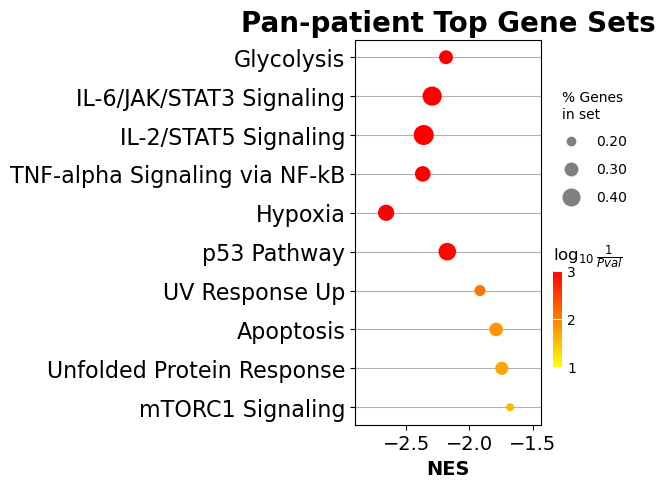

In [235]:
enr_res = gseapy.prerank(rnk=get_kinetic_log2fc(expr).query("pval < 0.05")["log2_fc"], gene_sets='MSigDB_Hallmark_2020')
print([enr_res.res2d.Term[i] for i in range(10)])
enr_res.res2d["Adjusted P-value"] = enr_res.res2d["FDR q-val"]
gseapy.dotplot(enr_res.res2d, figsize=(3,5), title=f"Pan-patient Top Gene Sets", cmap = plt.cm.autumn_r, show_category=True)

## Look at specific T cell phenotype gene lists

In [224]:
import json
with open("T_cell_gene_lists.json", "r") as f:
    t_cell_gene_lists = json.load(f)
t_cell_gene_lists.keys()

dict_keys(['T_Cell_Exhaustion', 'TCR_signaling', 'T_Cell_Checkpoints', 'Senescence_Quiescence', 'T_Cell_Memory'])

T cell exhaustion genes


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


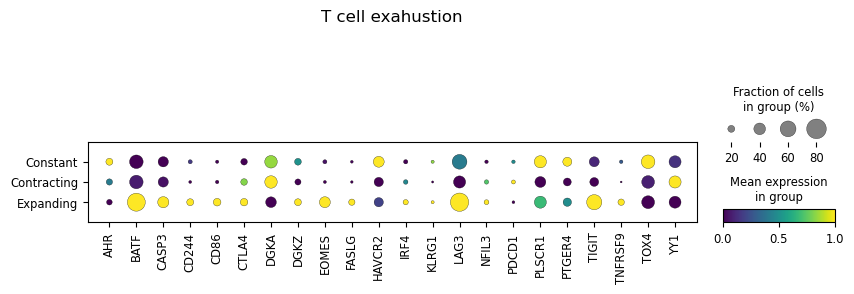

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


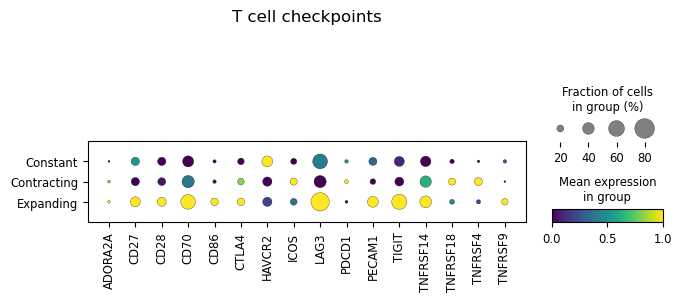

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


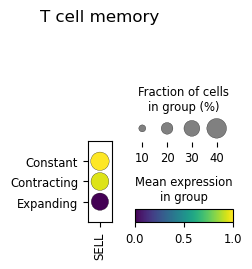

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


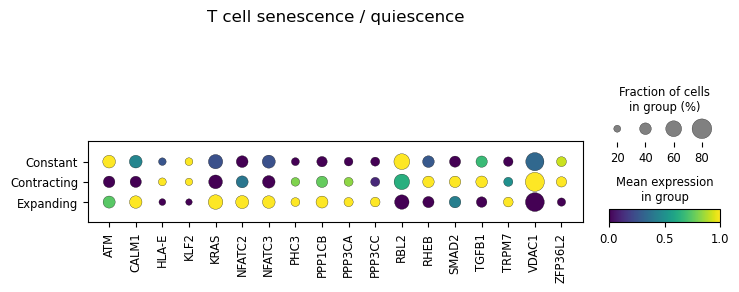

In [229]:
expr_subset=expr[expr.obs.time_point_type == "IP"]
print("T cell exhaustion genes")
genes_to_plot = [g for g in t_cell_gene_lists["T_Cell_Exhaustion"] if g in expr_subset.var.index and expr_subset.var.loc[g,"n_cells_by_counts"] > 2000]
sc.pl.dotplot(expr_subset, var_names=genes_to_plot, groupby="kinetics", use_raw=False, standard_scale="var", color_map="viridis", title="T cell exahustion")

genes_to_plot = [g for g in t_cell_gene_lists["T_Cell_Checkpoints"] if g in expr_subset.var.index and expr_subset.var.loc[g,"n_cells_by_counts"] > 2000]
sc.pl.dotplot(expr_subset, var_names=genes_to_plot, groupby="kinetics", use_raw=False, standard_scale="var", color_map="viridis", title="T cell checkpoints")

genes_to_plot = [g for g in t_cell_gene_lists["T_Cell_Memory"] if g in expr_subset.var.index and expr_subset.var.loc[g,"n_cells_by_counts"] > 2000]
sc.pl.dotplot(expr_subset, var_names=genes_to_plot, groupby="kinetics", use_raw=False, standard_scale="var", color_map="viridis", title="T cell memory")

genes_to_plot = [g for g in t_cell_gene_lists["Senescence_Quiescence"] if g in expr_subset.var.index and expr_subset.var.loc[g,"n_cells_by_counts"] > 10000]
sc.pl.dotplot(expr_subset, var_names=genes_to_plot, groupby="kinetics", use_raw=False, standard_scale="var", color_map="viridis", title="T cell senescence / quiescence")

T cell exhaustion genes


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


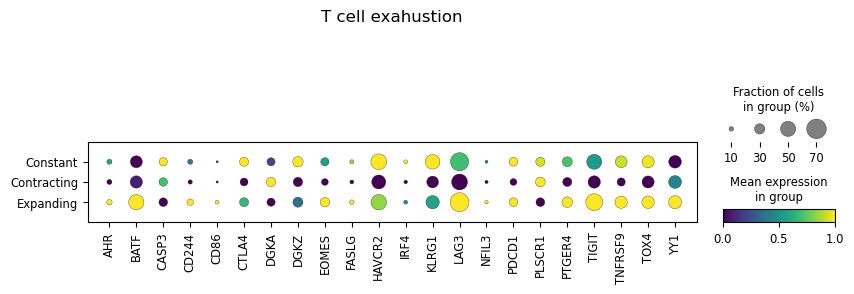

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


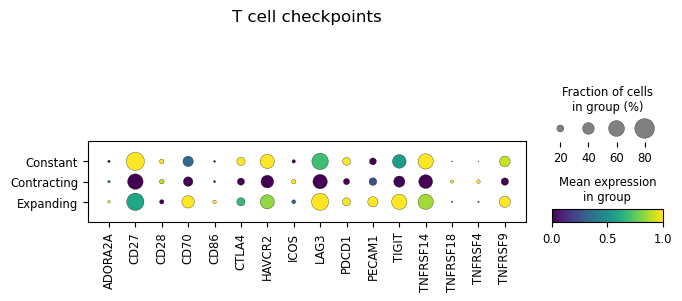

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


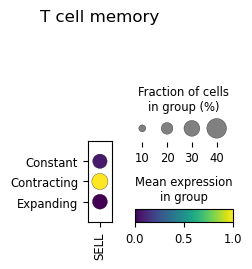

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


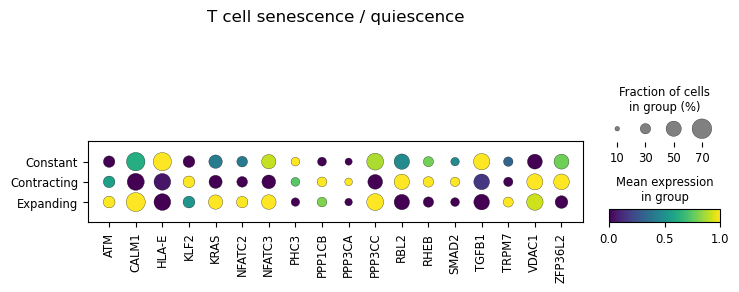

In [227]:
# expr_subset = expr_non_late[expr_non_late.obs.patient_id == "CLL-1"]
expr_subset=expr_non_late
print("T cell exhaustion genes")
genes_to_plot = [g for g in t_cell_gene_lists["T_Cell_Exhaustion"] if g in expr_subset.var.index and expr_subset.var.loc[g,"n_cells_by_counts"] > 2000]
sc.pl.dotplot(expr_subset, var_names=genes_to_plot, groupby="kinetics", use_raw=False, standard_scale="var", color_map="viridis", title="T cell exahustion")

genes_to_plot = [g for g in t_cell_gene_lists["T_Cell_Checkpoints"] if g in expr_subset.var.index and expr_subset.var.loc[g,"n_cells_by_counts"] > 2000]
sc.pl.dotplot(expr_subset, var_names=genes_to_plot, groupby="kinetics", use_raw=False, standard_scale="var", color_map="viridis", title="T cell checkpoints")

genes_to_plot = [g for g in t_cell_gene_lists["T_Cell_Memory"] if g in expr_subset.var.index and expr_subset.var.loc[g,"n_cells_by_counts"] > 2000]
sc.pl.dotplot(expr_subset, var_names=genes_to_plot, groupby="kinetics", use_raw=False, standard_scale="var", color_map="viridis", title="T cell memory")

genes_to_plot = [g for g in t_cell_gene_lists["Senescence_Quiescence"] if g in expr_subset.var.index and expr_subset.var.loc[g,"n_cells_by_counts"] > 10000]
sc.pl.dotplot(expr_subset, var_names=genes_to_plot, groupby="kinetics", use_raw=False, standard_scale="var", color_map="viridis", title="T cell senescence / quiescence")

### Look into expression of an individual clone over time

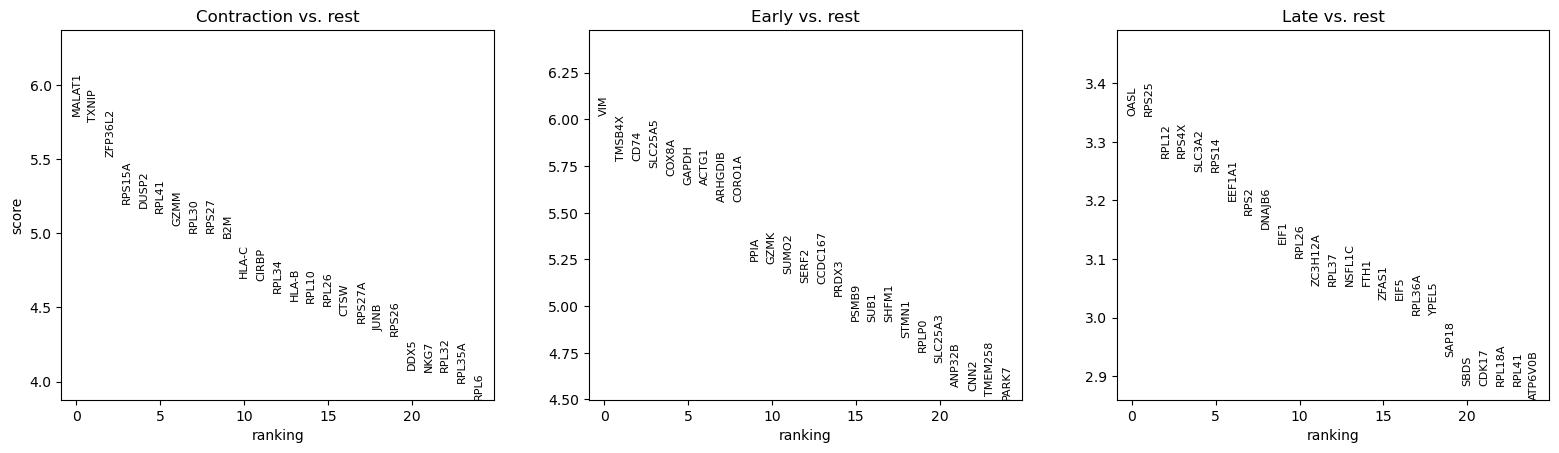

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


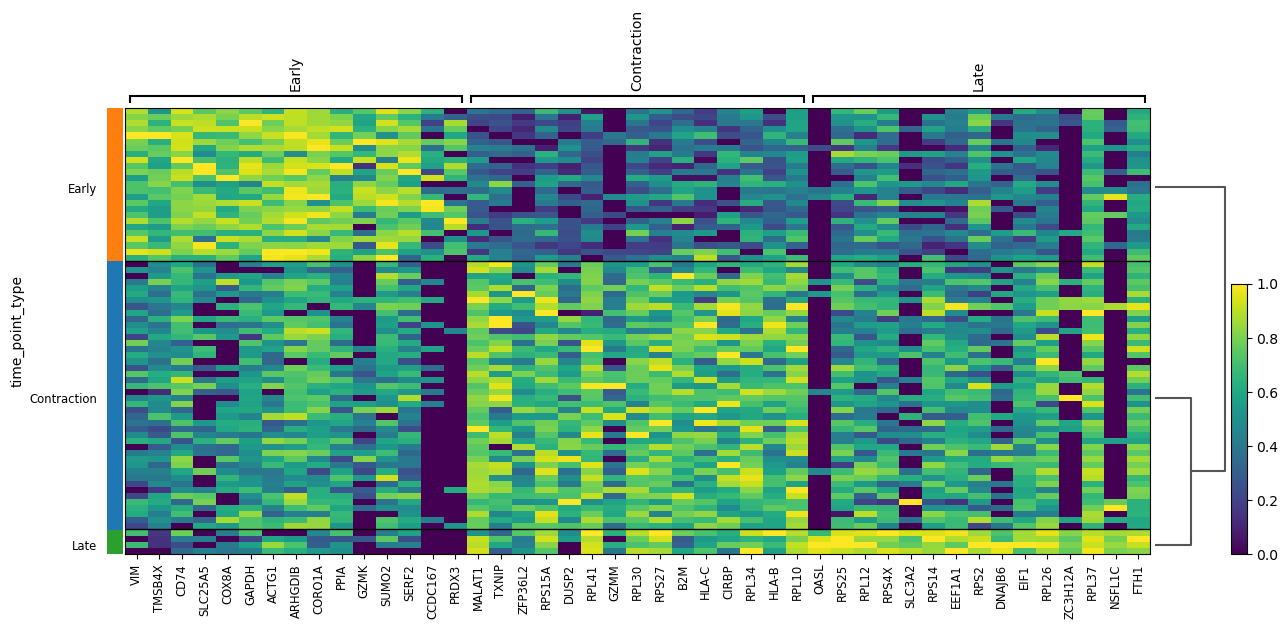

In [94]:
clone_id = "NHL-7-923"
expr_for_clone = expr[expr.obs.clone_id == clone_id].copy()
sc.tl.rank_genes_groups(expr_for_clone, groupby="time_point_type", method="wilcoxon", n_genes=1000)
sc.pl.rank_genes_groups(expr_for_clone, n_genes=25, sharey=False)
sc.pl.rank_genes_groups_heatmap(expr_for_clone, n_genes = 15, key="rank_genes_groups", groupby="time_point_type", show_gene_labels=True, standard_scale="var")